<h1 style="text-align:center;font-size:30px;" > Capacity Estimation of Li-ion battery </h1>

<h1> 1. Business Problem </h1>

<h2>1.1 Description</h2>

Battery is a combination of various electrochemical cells that generate electricity by converting chemical to electrical energy. One such class of batteries is Lithium-ion battery. Lithium-ion batteries have long life, high specific power and high energy density and hence they are widely used in Electric Vehicles, Electronic gadgets etc. But the proper functioning of these batteries warrants extensive monitoring of health so as to avoid any hazards and make them long lasting. Such a techniques used in the space of batteries is called Prognostics and Health Management (PHM) of batteries. With PHM it is possible to predict any failure of the batteries well in time so as to take appropriate preventive or corrective measures.

The part of the PHM that monitors all the parameters of the batteries is called the Battery Management System (BMS). One such parameter that is monitored by the BMS is called the Capacity of the battery or the State of Health (SoH). Capacity of a battery is defined as the ratio of the present maximum Charge in Ah to the rated initial maximum Charge of the battery in Ah. For example if the battery had an initial rated maximum Charge of 100 Ah and over a period of time the maximum Charge that can be held by the battery is 80 Ah then the Capacity of the Battery is 80/100 = 0.8. But capacity of a battery cannot be measured directly from its terminals. 


<h3>1.2 Problem to solve</h3>


The task here is to predict the instantaneous capacity of the battery given current, voltage, temperature values sampled at certain intervals from the charge/discharge cycles. In the dataset there is an impedance cycle which is given but we have not considered it in our modeling because impedance measurement is not possible online in any Electric vehicle or Electronic gadgets etc. as it requires instruments such as electrochemical impedance spectroscope. 
Capacity: How much maximum charge that a battery can hold at any given charging cycle instant. 
Charge/Discharge Cycle: It’s the period of time required to completely charge and subsequently discharge a battery.  




<h1>2. Machine Learning Probelm </h1>

<h3>2.1 ML formulation of the business problem:</h3>

The target variable is Capacity which is a continuous variable hence it’s a regression problem. 

<h3>2.2 Business Constraints:</h3>

•	There is no sub-second latency constraint however training should not too long a time to finish.

•	Since State of Health is a very critical part of BMS so it should be predicted with as much accuracy as possible. 

•	Noise and Outliers are part of the dataset which needs to be taken extreme care of in order to improve accuracy of the model. 


<h3>2.3 Dataset:  </h3>

•	The dataset that is taken to model our task of prediction of Capacity is supplied by Prognostics Centre of Excellence under National Aeronautics and Space Administration. 

•	The link to the dataset is https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/publications/#battery

•	Here a type of Lithium-ion battery called 18650 series is run through many charge/discharge cycles and sampled values of voltage, current and temperature is supplied in the dataset.


<h3>2.4 Data structure</h3>

<h3>2.5 Performance metric:</h3>

Since it’s a standard regression task so the metric for testing the model’s performance is taken to be mean squared error. Additionally we can take mean absolute error to get the absolute mean values of errors.

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat 
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt

<h3> 3.1 Reading the matlab data files of the four batteries namely: B0005, B0006, B0007 and B0018</h3>


In [2]:
battery_lst = ["B0005","B0006","B0007","B0018"]
data_lst = []
for battery in battery_lst:
    #Here '5_6_7_18' where all the matlab files with names B0005","B0006","B0007","B0018 are kept
    data_lst.append(loadmat('5_6_7_18/'+battery+'.mat'))

In [3]:
#Below code snippet is taken from 
#https://stackoverflow.com/questions/41641205/how-to-avoid-output-into-scrollable-frames-in-jupyter-notebook
#So that plot don't become scrollable

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<h3> 3.1 Putting the matlab data into a list of custom dictionaries for various batteries</h3>

In [5]:
def read_data(data,battery):
    
    """
    This function takes two inputs: Matlab converted Dictionary data and the Battery name
    and outputs a list of dictionaries containing all the voltage, current and temperature info
    for the various charge/discharge cycles. We here have three different types of dictionary structure
    for the charge, discharge and impedance cycle.
    
    The dictionary for charge cycle has the following structure:
    {
        'type': charge,
        'ambient_temperature' : single_value,
        'time' : single_value,
        'Voltage_measured' : array,
        'Current_measured' : array,
        'Temperature_measured' : array,
        'Current_charge' : array,
        'Voltage_charge' : array,
        'Time' : array
    }
    
    The dictionary for discharge cycle has the following structure:
    {
        'type': discharge,
        'ambient_temperature' : single_value,
        'time' : single_value,
        'Voltage_measured' : array,
        'Current_measured' : array,
        'Temperature_measured' : array,
        'Current_load' : array,
        'Voltage_load' : array,
        'Time' : array,
        'Capacity' : single_value
    }
    
    The dictionary for impedance cycle has the following structure:
    {
        'type': impedance,
        'ambient_temperature' : single_value,
        'time' : single_value,
        'Sense_current' : array,
        'Battery_current' : array,
        'Current_ratio' : array,
        'Battery_impedance' : array
    }
    """
    
    
    #This list holds the voltage,current and temperature information arranged as dictionary for all the cycles 
    cycle_lst = []
    idx = 0
    
    #Parsing through all the cycles and putting the information into respective dictionary type and finally
    #appending the dictionary into the list 'cycle_lst' 
    
    #Parsing all the cycles namely charge, discharge and impedance
    for i in data[battery][0,0]['cycle'][0]:
        cycle_info_dict = {}
        if i['type'][0] == "charge":
            cycle_info_dict['type'] = 'charge'
            cycle_info_dict['ambient_temperature'] = i['ambient_temperature'][0][0]
            cycle_info_dict['time'] = i['time'][0][0]
            cycle_info_dict['Voltage_measured'] = i['data'][0]['Voltage_measured'][0][0]
            cycle_info_dict['Current_measured'] = i['data'][0]['Current_measured'][0][0]
            cycle_info_dict['Temperature_measured'] = i['data'][0]['Temperature_measured'][0][0]
            cycle_info_dict['Current_charge'] = i['data'][0]['Current_charge'][0][0]
            cycle_info_dict['Voltage_charge'] = i['data'][0]['Voltage_charge'][0][0]
            cycle_info_dict['Time'] = i['data'][0]['Time'][0][0]
            cycle_lst.append(cycle_info_dict)
        
        elif i['type'][0] == "discharge":
            cycle_info_dict['type'] = 'discharge'
            cycle_info_dict['ambient_temperature'] = i['ambient_temperature'][0][0]
            cycle_info_dict['time'] = i['time'][0][0]
            cycle_info_dict['Voltage_measured'] = i['data'][0]['Voltage_measured'][0][0]
            cycle_info_dict['Current_measured'] = i['data'][0]['Current_measured'][0][0]
            cycle_info_dict['Temperature_measured'] = i['data'][0]['Temperature_measured'][0][0]
            cycle_info_dict['Current_load'] = i['data'][0]['Current_load'][0][0]
            cycle_info_dict['Voltage_load'] = i['data'][0]['Voltage_load'][0][0]
            cycle_info_dict['Time'] = i['data'][0]['Time'][0][0]
            cycle_info_dict['Capacity'] = i['data'][0]['Capacity'][0][0][0]
            cycle_lst.append(cycle_info_dict) 
        
        elif i['type'][0] == "impedance":
            cycle_info_dict['type'] = 'impedance'
            cycle_info_dict['ambient_temperature'] = i['ambient_temperature'][0][0]
            cycle_info_dict['time'] = i['time'][0][0]
            cycle_info_dict['Sense_current'] = i['data'][0]['Sense_current'][0][0]
            cycle_info_dict['Battery_current'] = i['data'][0]['Battery_current'][0][0]
            cycle_info_dict['Current_ratio'] = i['data'][0]['Current_ratio'][0][0]
            cycle_info_dict['Battery_impedance'] = i['data'][0]['Battery_impedance'][0][0]
            cycle_lst.append(cycle_info_dict) 
        idx += 1
        
    return cycle_lst

In [6]:
#showing the data structure of data_dict dictionary
"""
data_dict is a dictionary of the format
data_dict = {
    'B0005' : cycle_lst for battery B0005,
    'B0006' : cycle_lst for battery B0006,
    'B0007' : cycle_lst for battery B0007,
    'B0018' : cycle_lst for battery B0018
}
"""
data_dict = {}
idx = 0
for data in data_lst:
    data_dict[battery_lst[idx]] = read_data(data,battery_lst[idx]) #read_data function returns a list of custom dictionaries
    idx += 1
for key,values in data_dict.items():
    print(key)

B0005
B0006
B0007
B0018


<h2>3.2 Counting the number of charge/discharge/impedance cycles<h2>

In [7]:
def cycle_count(cycle_lst):
    
    """
        This fuction takes the list of charge/discharge/impedance cycle information as input
        and gives the number of charge, discharge and impedance cycles in the list as output.
        The output has a dictionary format:
        cycle_dict = 
            {"charge":#charge-cycles,
            "discharge":#discharge-cycles,
            "impedance":#impedance-cycles}
    """
    cycle_dict = {"charge":0,
              "discharge":0,
              "impedance":0}
    for i in cycle_lst:
        if i['type'] == "discharge":
            cycle_dict["discharge"] += 1
        elif i['type'] == "charge":
            cycle_dict["charge"] += 1
        else:
            cycle_dict["impedance"] += 1
    return cycle_dict

In [8]:
"""
    We have here a dictionary of dictionary 'cycle_count_dict'. It has the format
    cycle_count_dict = {
            'B0005' : cycle_dict for battery B0005,
            'B0006' : cycle_dict for battery B0006,
            'B0007' : cycle_dict for battery B0007,
            'B0018' : cycle_dict for battery B0018
    }
    where
    cycle_dict = 
            {"charge":#charge-cycles,
            "discharge":#discharge-cycles,
            "impedance":#impedance-cycles}
"""
cycle_count_dict = {}

"""
data_dict = {
    'B0005' : cycle_lst for battery B0005, #cycle_lst has list of different dictionaries
    'B0006' : cycle_lst for battery B0006,
    'B0007' : cycle_lst for battery B0007,
    'B0018' : cycle_lst for battery B0018
}
"""
for key,val in data_dict.items():
    cycle_count_dict[key] = cycle_count(val)

In [9]:
for k,v in cycle_count_dict.items():
    for key,value in v.items():
        print("Number of {} cycles for battery {} is:: {}".format(key,k,value))
    print("*"*50)

Number of charge cycles for battery B0005 is:: 170
Number of discharge cycles for battery B0005 is:: 168
Number of impedance cycles for battery B0005 is:: 278
**************************************************
Number of charge cycles for battery B0006 is:: 170
Number of discharge cycles for battery B0006 is:: 168
Number of impedance cycles for battery B0006 is:: 278
**************************************************
Number of charge cycles for battery B0007 is:: 170
Number of discharge cycles for battery B0007 is:: 168
Number of impedance cycles for battery B0007 is:: 278
**************************************************
Number of charge cycles for battery B0018 is:: 134
Number of discharge cycles for battery B0018 is:: 132
Number of impedance cycles for battery B0018 is:: 53
**************************************************


We can see that the charge, discharge and impedance cycles for the batteries are not the same. However, the number of such cycles is the same for battery B0005, B0006 and B0007 but for B0018 the values are different. But in any case, the number of 
charge and discharge cycles should be the same. There cannot be any charge-charge or discharge-dischage cycles consecutively.
Hence there are possibilities of outlier cycles in the dataset which we need to identify and remove from our dataset.

<h3>3.2.1 Now plotting the histogram plot for the number of charge, discharge and impedance cycles for 
the various batteries.</h3> 

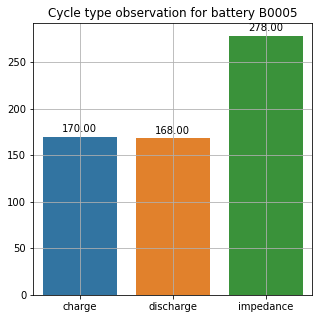

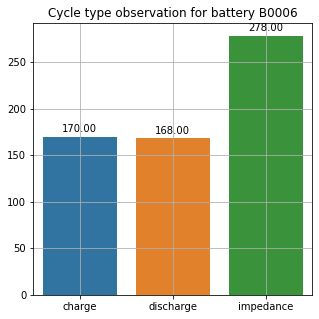

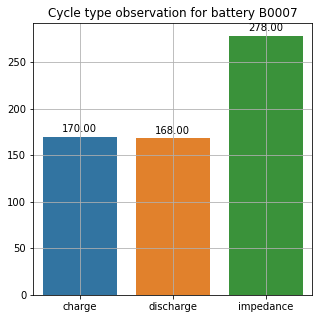

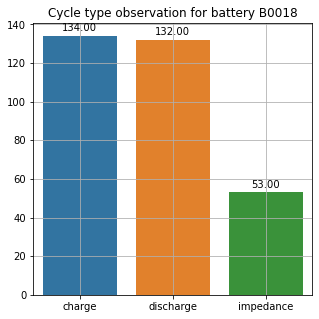

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

for key,val in cycle_count_dict.items():
    plt.figure(figsize=(5,5))
    plt.title('Cycle type observation for battery {}'.format(key))
    ax = sns.barplot(x=list(val.keys()), 
            y=list(val.values()))

    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

    plt.grid()
    plt.show()

<h3>3.3 Finding the counts of the number of datapoints in charge/discharge/impedance cycles</h3>

In [11]:
def count(cycle_lst):
    """
        This fuction takes the charge/discharge/impedance information for the various batteries 
        and gives output the following information in a list:
        1. A dictionary 'cycle_num_dict' indicating the indices for the charge/discharge and impedance cycles
        2. A dictionary 'value_dict' containing the list of all the time arrays for the various cycles
        3. A dictionary 'count_dict' containing the number of elements in the time arrays for the various cycles
    """
    
    #It contains the indices for the various cycles for a given battery
    cycle_num_dict = {"charge":[],
                  "discharge":[],
                  "impedance":[]}
    #It contains the actual time array values for charge/discharge/impedance cycles for a given battery
    value_dict = {"charge":[],
                  "discharge":[],
                  "impedance":[]}
    #It contains th number of sample values in charge/discharge/impedance cycles for a given battery 
    count_dict = {"charge":[],
                  "discharge":[],
                  "impedance":[]}
    idx = 0
    for i in cycle_lst:
        if i["type"] == "charge":
            time =i['Time']
            cycle_num_dict['charge'].append(idx)
            value_dict['charge'].append(time)
            count_dict['charge'].append(time.shape[0])
        elif i["type"] == "discharge":
            time = i['Time']
            cycle_num_dict['discharge'].append(idx)
            value_dict['discharge'].append(time)
            count_dict['discharge'].append(time.shape[0])
        elif i["type"] == "impedance":
            cur = i['Sense_current']
            cycle_num_dict['impedance'].append(idx)
            value_dict['impedance'].append(cur)
            count_dict['impedance'].append(cur.shape[0])
        idx += 1
    return [cycle_num_dict,value_dict,count_dict]

In [12]:
"""
    Here the 'cycle_info_dict' contains the dictionaries 'cycle_num_dict','value_dict','count_dict' 
    for the various batteries
"""
cycle_info_dict = {}
for key,value in data_dict.items():
    cycle_info_dict[key] = count(value)
    

<h3>3.3.1 Plotting the histogram plot for the sample counts during charge cycles for the various batteries. That is 
different charge cycles have different number of samples taken for the voltage/current values at different instants
of time. Here the different sample counts are investigated to see if there exist some cycles with extremly large or small 
number of samples which would be considered as outliers.</h3> 

The plot is read as: Number of charge cycles having sample count given x-axis value = y-axis value


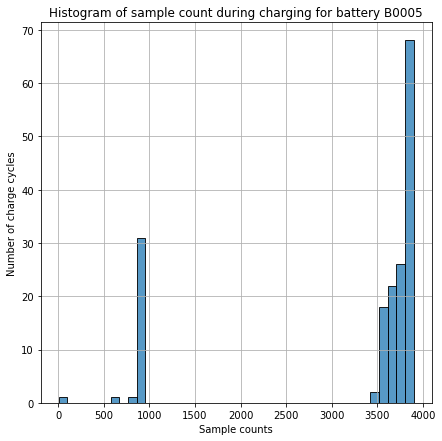

Min number of samples in charge :  5
Max number of samples in charge :  3900
25th 50th and 75th Percentiles for the number of samples:  [3565.25 3738.5  3834.75] 



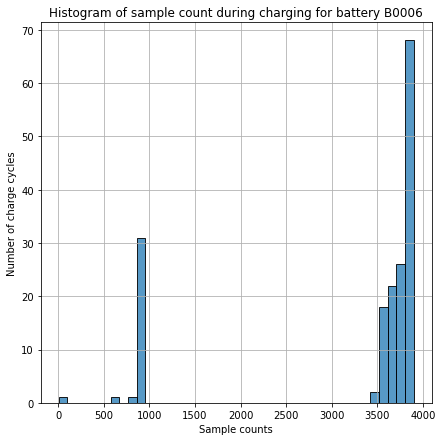

Min number of samples in charge :  5
Max number of samples in charge :  3900
25th 50th and 75th Percentiles for the number of samples:  [3565.25 3738.5  3834.75] 



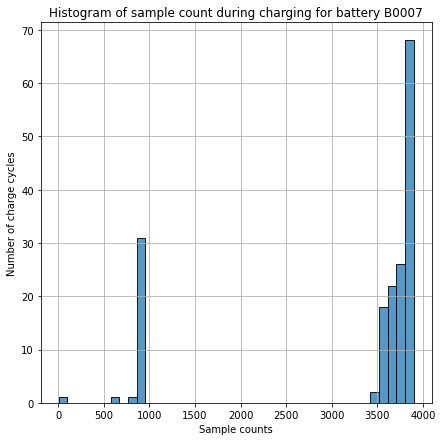

Min number of samples in charge :  5
Max number of samples in charge :  3900
25th 50th and 75th Percentiles for the number of samples:  [3565.25 3738.5  3834.75] 



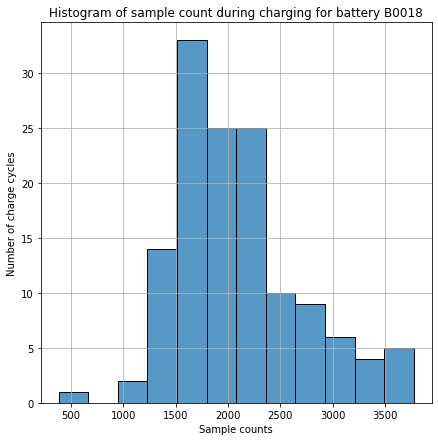

Min number of samples in charge :  381
Max number of samples in charge :  3777
25th 50th and 75th Percentiles for the number of samples:  [1638.25 1966.5  2370.75] 



In [13]:
"""
    Here the 'cycle_info_dict' contains the dictionaries 'cycle_num_dict','value_dict','count_dict' 
    for the various batteries
"""
print("The plot is read as: Number of charge cycles having sample count given x-axis value = y-axis value")
for key,value in cycle_info_dict.items():
    plt.figure(figsize=(7,7))
    #Here value contains the list of dictionaries of which the third element is the dictionary
    #which contains the number of samples taken for various types of cycles
    #Here values[2] is refering to the count_dict dictionary
    sns.histplot(value[2]['charge'])
    plt.title('Histogram of sample count during charging for battery '+key)
    plt.xlabel("Sample counts")
    plt.ylabel("Number of charge cycles")
    plt.grid()
    plt.show()

    print('Min number of samples in charge : ', min(value[2]['charge']))
    print('Max number of samples in charge : ', max(value[2]['charge']))
    print('25th 50th and 75th Percentiles for the number of samples: ', np.percentile(value[2]['charge'], [25,50, 75]),'\n')

From the plots it is seen that not all charge cycles have the same number of samples. Also we can see that the 
distribution of the sample count vs number of cycles is identical for battery B0005, B0006 and B0007 but different for
battery B0018. For the first three batteries, minimum number of sample count is 5 which is absurb and can be reckoned 
as an outlier and removed. So a threshold of 500 is taken, below which all the cycles having sample count lesser is 
taken as an outlier for all the batteries. 

<h3>3.3.2 Plotting the histogram plot for the sample counts during discharge cycles for the various batteries. That is 
different discharge cycles have different number of samples taken for the voltage/current values at different instants
of time. Here the different samples counts are investigated to see if there exist some cycles with extremly large or small 
number of samples which would be considered as outliers.</h3> 

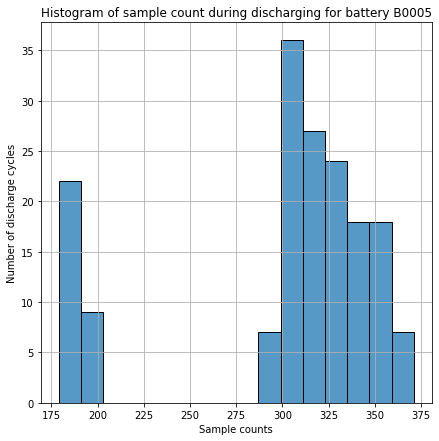

Min value in discharge :  179
Max value in discharge :  371
25th 50th and 75th Percentiles values:  [300.   314.5  335.25] 



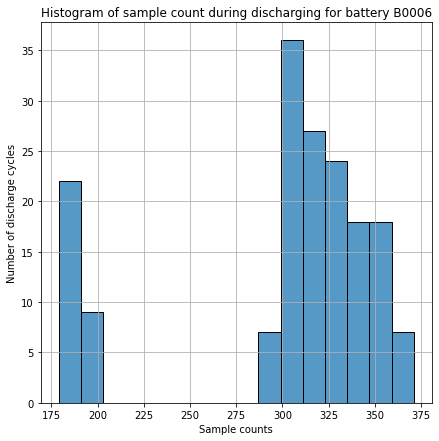

Min value in discharge :  179
Max value in discharge :  371
25th 50th and 75th Percentiles values:  [300.   314.5  335.25] 



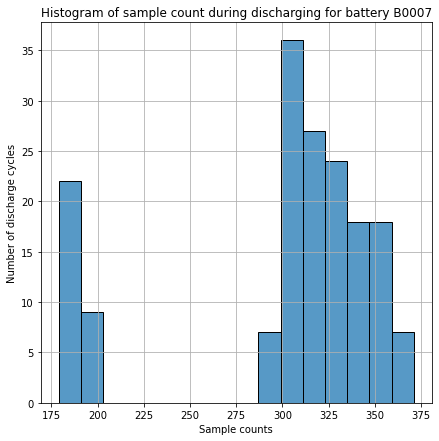

Min value in discharge :  179
Max value in discharge :  371
25th 50th and 75th Percentiles values:  [300.   314.5  335.25] 



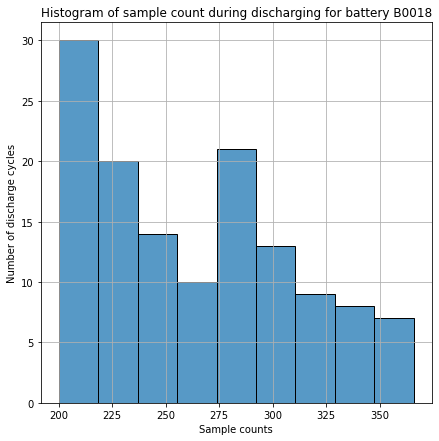

Min value in discharge :  200
Max value in discharge :  366
25th 50th and 75th Percentiles values:  [221.75 258.   298.  ] 



In [14]:
for key,value in cycle_info_dict.items():
    plt.figure(figsize=(7,7))
    sns.histplot(value[2]['discharge'])
    plt.title('Histogram of sample count during discharging for battery '+key)
    plt.xlabel("Sample counts")
    plt.ylabel("Number of discharge cycles")
    plt.grid()
    plt.show()

    print('Min value in discharge : ', min(value[2]['discharge']))
    print('Max value in discharge : ', max(value[2]['discharge']))
    print('25th 50th and 75th Percentiles values: ', np.percentile(value[2]['discharge'], [25,50, 75]),'\n')

Here we can see that the max value of sample count is around 400 and min value is around 200 for all the batteries.
Also the distribution is same for the first three batteries and different for B0018. As there is not significantly high
or low value count compared to the average value, so we can say that there is no outlier datapoints in the discharge 
cycles with respect to the sample size.

<h3>3.3.3 Plotting the histogram plot for the sample counts during impedance cycles for the various batteries</h3>

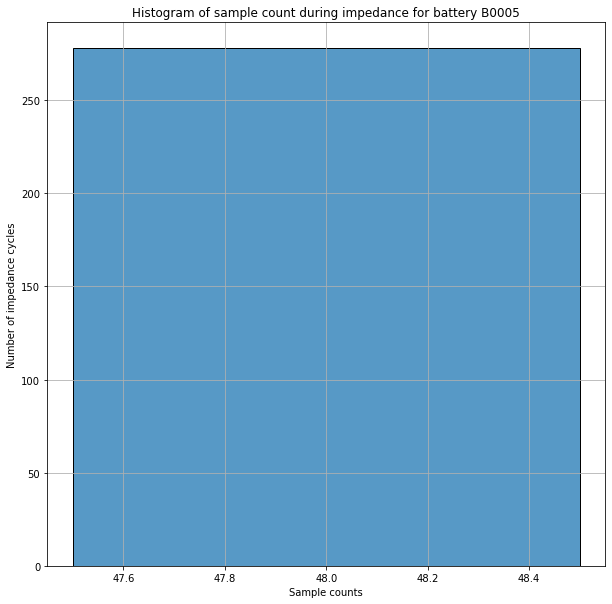

Min value in impedance :  48
Max value in impedance :  48
25th 50th and 75th Percentiles values:  [48. 48. 48.] 



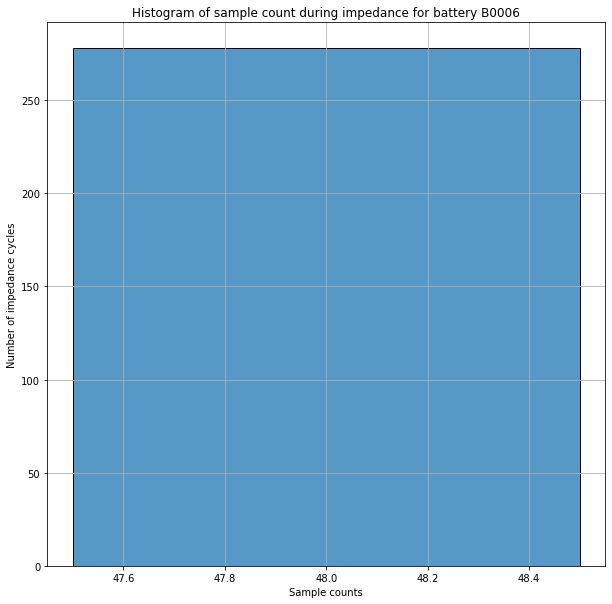

Min value in impedance :  48
Max value in impedance :  48
25th 50th and 75th Percentiles values:  [48. 48. 48.] 



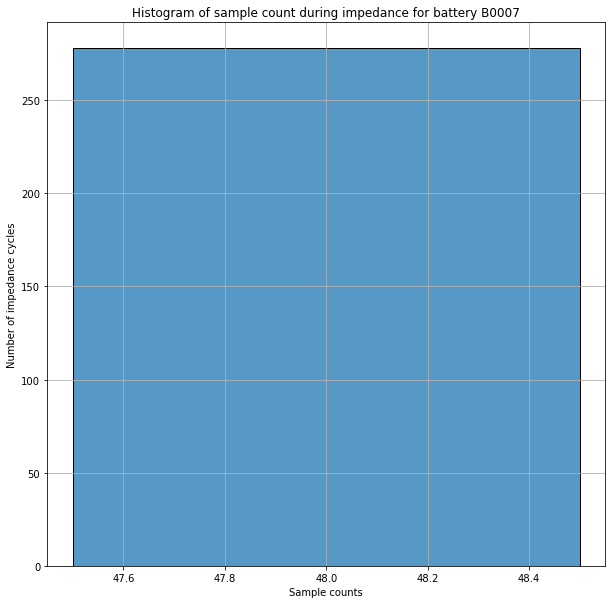

Min value in impedance :  48
Max value in impedance :  48
25th 50th and 75th Percentiles values:  [48. 48. 48.] 



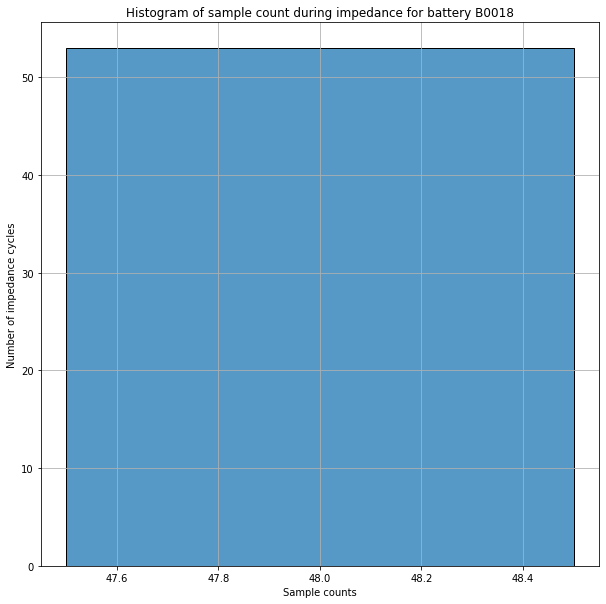

Min value in impedance :  48
Max value in impedance :  48
25th 50th and 75th Percentiles values:  [48. 48. 48.] 



In [15]:
for key,value in cycle_info_dict.items():
    plt.figure(figsize=(10,10))
    sns.histplot(value[2]['impedance'])
    plt.title('Histogram of sample count during impedance for battery '+key)
    plt.xlabel("Sample counts")
    plt.ylabel("Number of impedance cycles")
    plt.grid()
    plt.show()

    print('Min value in impedance : ', min(value[2]['impedance']))
    print('Max value in impedance : ', max(value[2]['impedance']))
    print('25th 50th and 75th Percentiles values: ', np.percentile(value[2]['impedance'], [25,50, 75]),'\n')

Here we get to see that all the impedance cycles have the same number of samples of 48. However, in the analysis for 
State of Health or Capacity of a battery, impedance is not taken into account, considering the practicality
of measurement. Impedance is measured with an  electrochemical impedance spectroscope (EIS) under controlled conditions which is not possible to be measured online in any device using Lithium-ion battery. Hence the analysis will take only the charge 
and discharge cycle values.

<h3>3.4 Analysing the Lenght of time sample sets and the max values in time sample sets in charge cycles</h3>

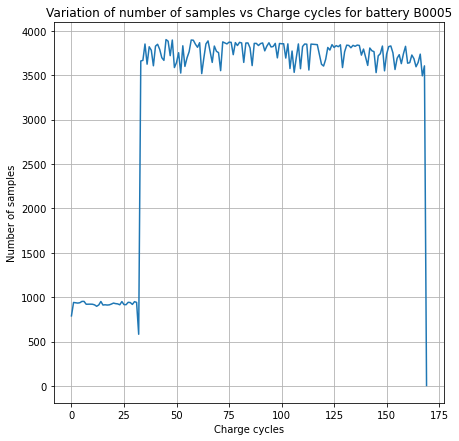

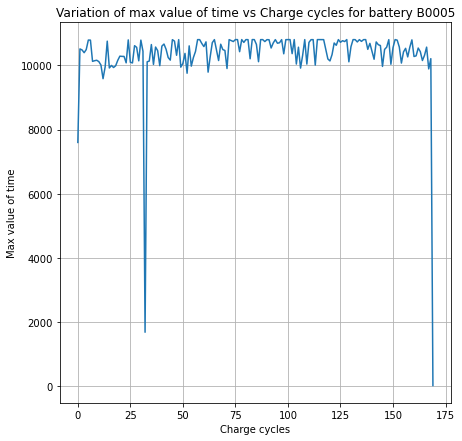

No. of charge cycles having sample lenght less that 3300 for battery B0005 is 34
No. of charge cycles having sample lenght less that 600 for battery B0005 is 2


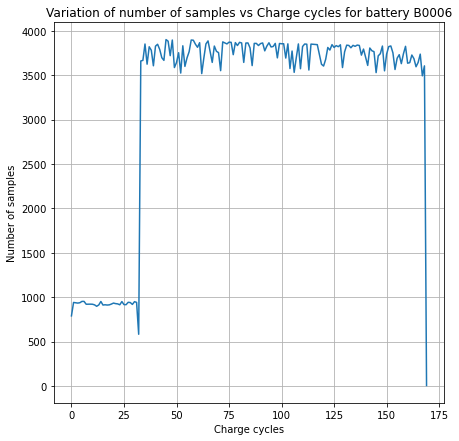

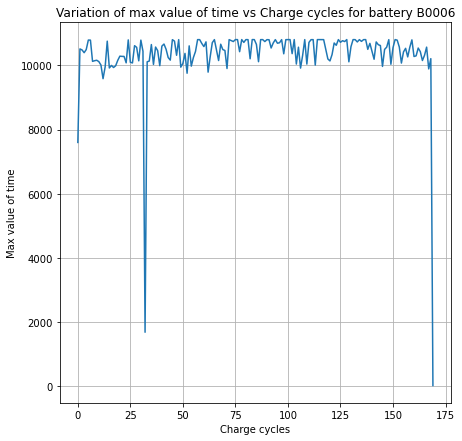

No. of charge cycles having sample lenght less that 3300 for battery B0006 is 34
No. of charge cycles having sample lenght less that 600 for battery B0006 is 2


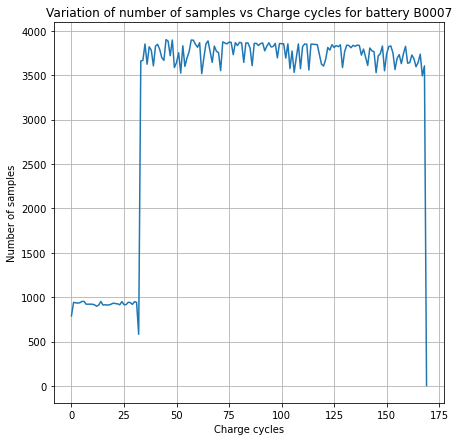

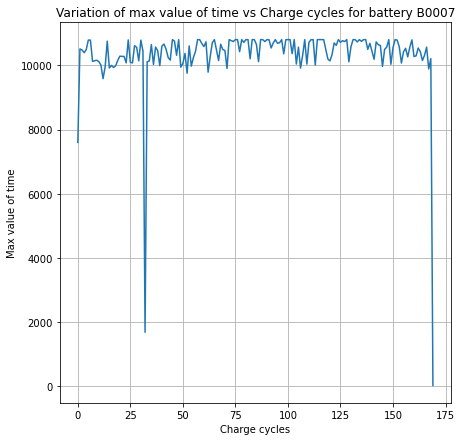

No. of charge cycles having sample lenght less that 3300 for battery B0007 is 34
No. of charge cycles having sample lenght less that 600 for battery B0007 is 2


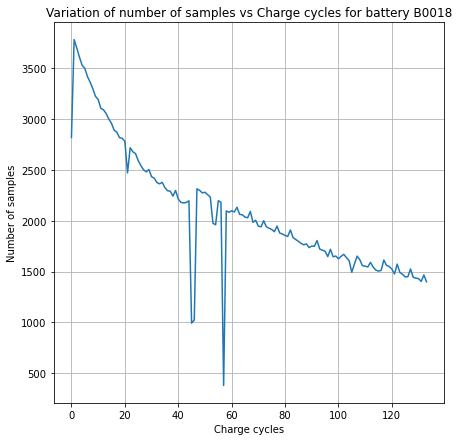

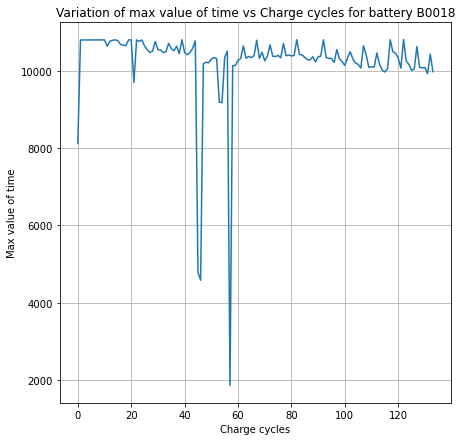

No. of charge cycles having sample lenght less that 3300 for battery B0018 is 127
No. of charge cycles having sample lenght less that 600 for battery B0018 is 1


In [16]:
"""
    Here the 'cycle_info_dict' contains the dictionaries 'cycle_num_dict','value_dict','count_dict' 
    for the various batteries
"""
for key,value in cycle_info_dict.items():
    #Here value contains the list of dictionaries of which the second element is the dictionary
    #which contains the values of time samples taken for various types of cycles
    #Here values[1] is refering to the cycle_num_dict dictionary
    plt.figure(figsize=(7,7))
    plt.plot([len(i) for i in value[1]['charge']])
    plt.xlabel('Charge cycles')
    plt.ylabel("Number of samples")
    plt.title("Variation of number of samples vs Charge cycles for battery " +key )
    plt.grid()
    plt.show()


    plt.figure(figsize=(7,7))
    plt.plot([max(i) for i in value[1]['charge']])
    plt.xlabel('Charge cycles')
    plt.ylabel("Max value of time")
    plt.title("Variation of max value of time vs Charge cycles for battery " +key )
    plt.grid()
    plt.show()

    #counts of the number of observations lesser thar 3300 
    print('No. of charge cycles having sample lenght less that 3300 for battery',key,'is',len([i for i in value[1]['charge'] if len(i) < 3300]))

    #counts of the number of observations lesser thar 700 
    print('No. of charge cycles having sample lenght less that 600 for battery',key,'is',len([i for i in value[1]['charge'] if len(i) < 600]))

Looking at the plots for the number of samples vs the charge cycles, we see that the plots are same for the first three
batteries and different for the forth one. But in all the plots we see that there are certain cycles having very low 
number of samples i.e. less than 600. These low sample sized cycles are outliers for the analysis and would be removed
in the subsequent section. 

<h3>3.4.1 Finding the actual charge cycles which have sample counts less than 600</h3>

In [17]:
#This dictionary holds the outlier charge cycle indices for the various batteries. 
outlier_lst_dict = {}
for key,value in data_dict.items():
    #This list holds the indices for the outlier cycles for a particular battery
    low_sample_val_cyc = []
    idx = 0 
    for i in value:
        if i["type"] == "charge":
            if len(i['Time']) < 600:
                low_sample_val_cyc.append(idx)
        idx += 1
    outlier_lst_dict[key] = low_sample_val_cyc
    #these cycles are outliers and need to be removed 
print(outlier_lst_dict)

{'B0005': [84, 615], 'B0006': [84, 615], 'B0007': [84, 615], 'B0018': [139]}


<h3>3.4.2 Removing the outlier datapoints that have very low samples</h3>

In [18]:
for key,value in outlier_lst_dict.items():
    idx = 0
    for i in value: 
        a = data_dict[key].pop(i-idx)
        idx += 1

In [19]:
#updating the dictionary cycle_info_dict
cycle_info_dict = {}
for key,value in data_dict.items():
    cycle_info_dict[key] = count(value)

<h3>3.5 Analysing the Lenght of timestamps sets and the max values in time sets in discharge cycles</h3>

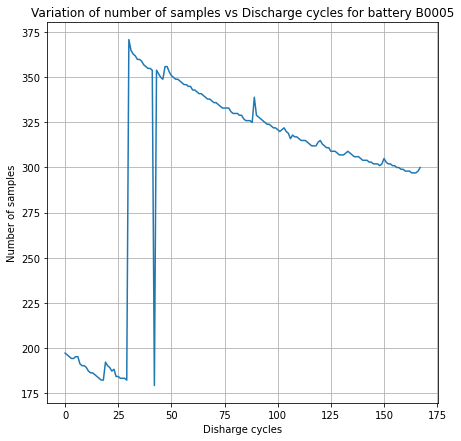

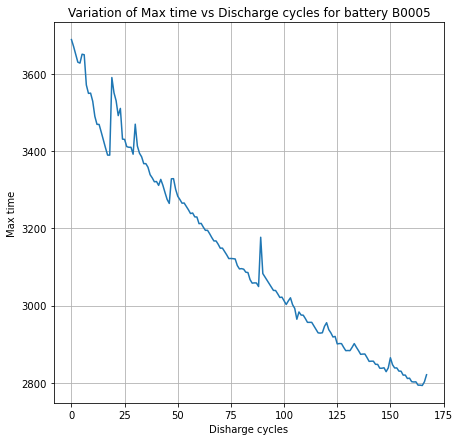

No. of discharge cycles having sample lenght less that 200 for battery: B0005 is 31


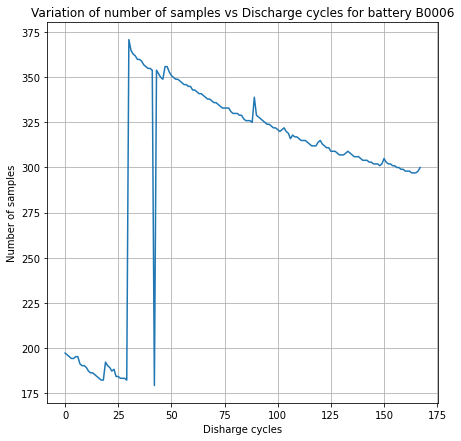

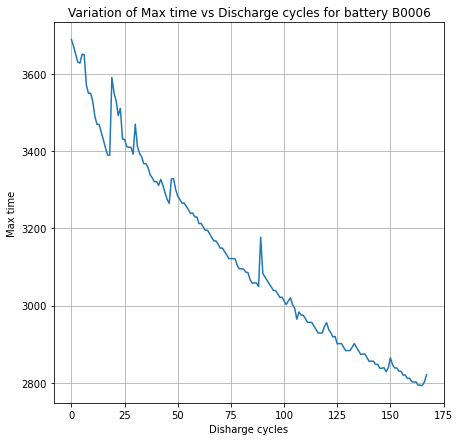

No. of discharge cycles having sample lenght less that 200 for battery: B0006 is 31


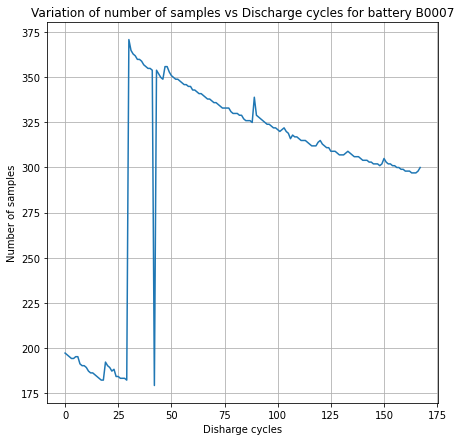

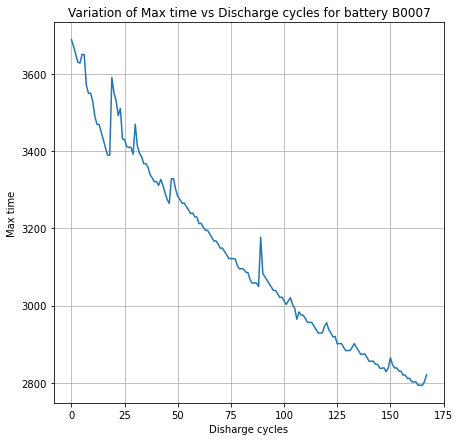

No. of discharge cycles having sample lenght less that 200 for battery: B0007 is 31


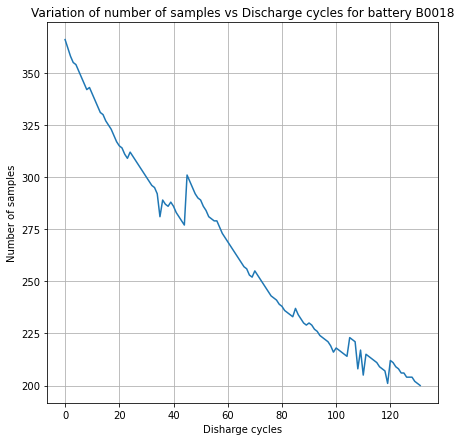

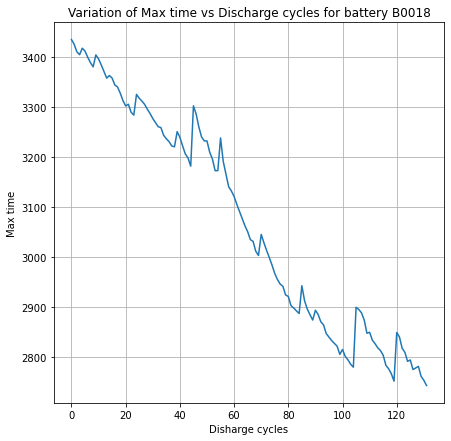

No. of discharge cycles having sample lenght less that 200 for battery: B0018 is 0


In [20]:
"""
    Here the 'cycle_info_dict' contains the dictionaries 'cycle_num_dict','value_dict','count_dict' 
    for the various batteries
"""

for key,value in cycle_info_dict.items():
    #Here value contains the list of dictionaries of which the second element is the dictionary
    #which contains the value of samples taken for various types of cycles
    #Here values[1] is refering to the cycle_num_dict dictionary
    plt.figure(figsize=(7,7))
    plt.plot([len(i) for i in value[1]['discharge']])
    plt.xlabel('Disharge cycles')
    plt.ylabel("Number of samples")
    plt.title("Variation of number of samples vs Discharge cycles for battery " +key )
    plt.grid()
    plt.show()


    plt.figure(figsize=(7,7))
    plt.plot([max(i) for i in value[1]['discharge']])
    plt.xlabel('Disharge cycles')
    plt.ylabel("Max time")
    plt.title("Variation of Max time vs Discharge cycles for battery " +key )
    plt.grid()
    plt.show()

    #counts of the number of observations lesser thar 200 
    print('No. of discharge cycles having sample lenght less that 200 for battery:',key,'is',len([i for i in value[1]['discharge'] if len(i) < 200]))

These are the plots for number of samples for the various dischage cycles. Here also the distribution is same for the 
first three batteries and different for the last one. Here there is no outlier cycles as said earlier. 

<h3>3.6 Plotting the first and last charge cycle for voltage, current and temperature</h3>

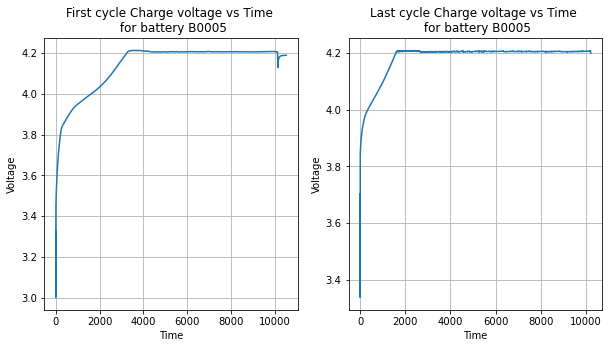

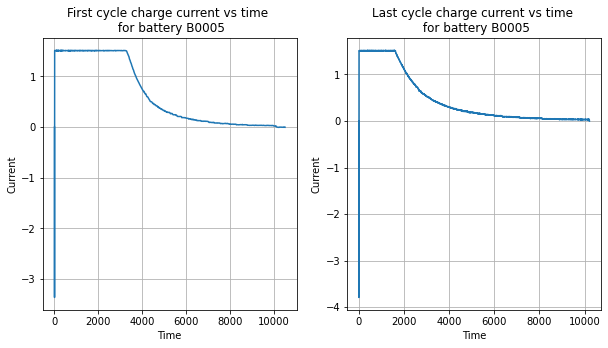

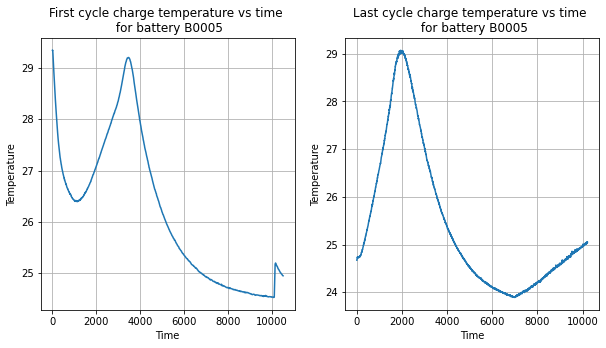

****************************************************************************************************


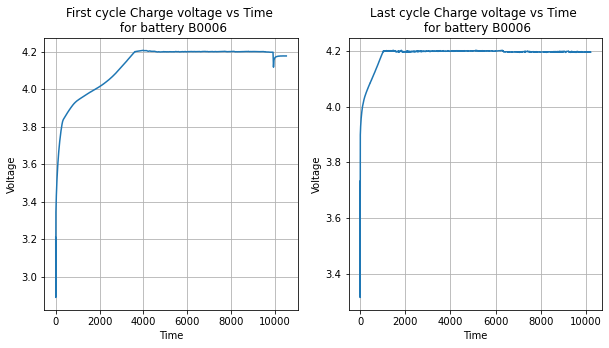

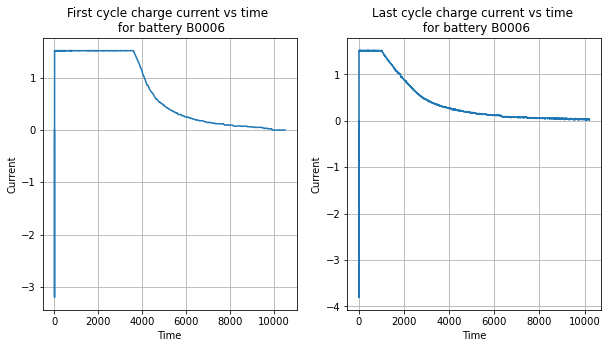

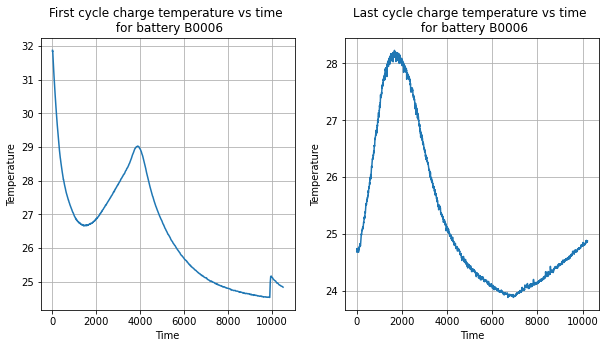

****************************************************************************************************


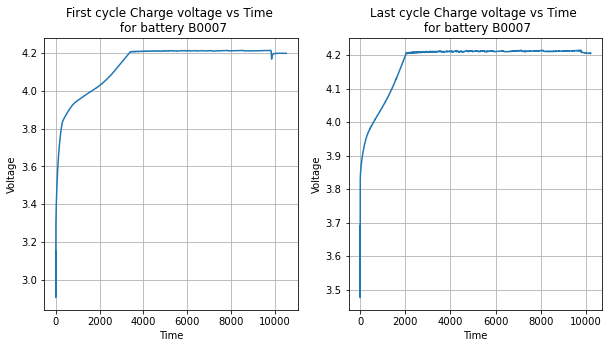

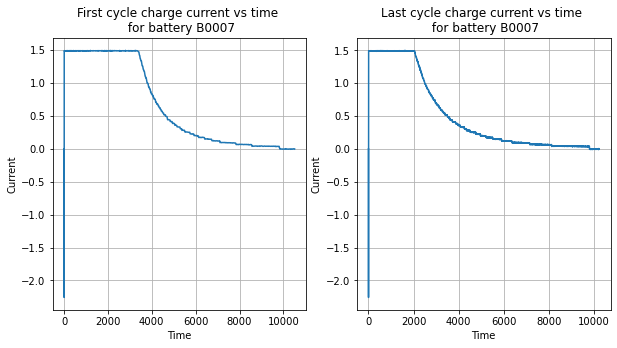

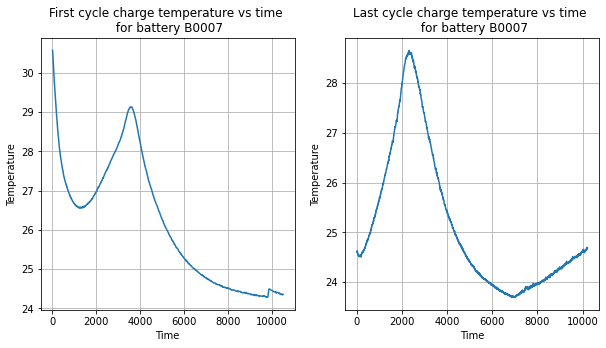

****************************************************************************************************


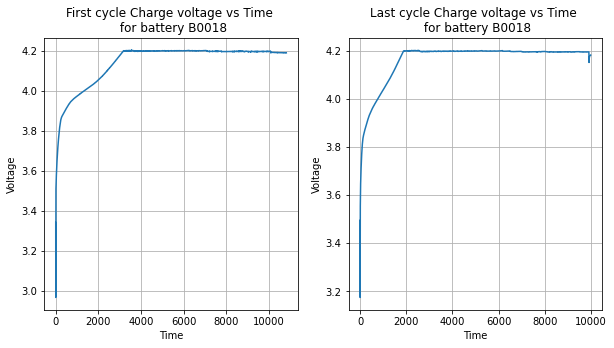

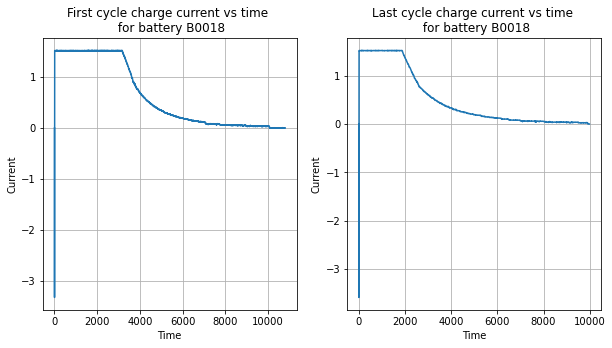

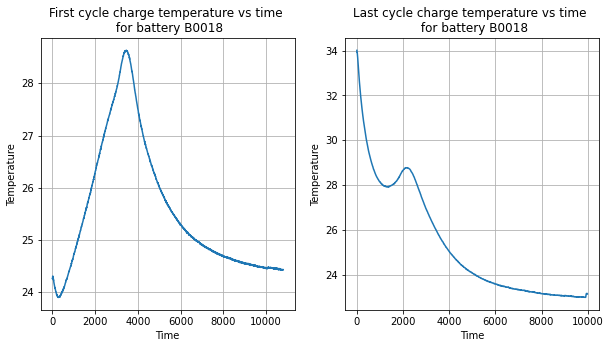

****************************************************************************************************


In [21]:
for key,value in cycle_info_dict.items():
#Plotting the Voltage_measured

    #value[0] is the dictionary 'cycle_num_dict' which contains the indices for the charge/discharge/impedance 
    #cycles for the various batteries. 
    first = value[0]['charge'][1]
    #first here is refering to the index of the first charge cycle of a given battery
    last = value[0]['charge'][-1]
    #last here is refering to the  index of the last charge cycle of a given battery
    Voltage_measured_first = data_dict[key][first]['Voltage_measured']
    #Voltage_measured_first is the 'voltage_measured' array for the first charge cycle
    time_first = data_dict[key][first]['Time']
    #time_first is the 'Time' array for the first charge cycle
    Voltage_measured_last = data_dict[key][last]['Voltage_measured']
    #Voltage_measured_last is the 'voltage_measured' array for the last charge cycle
    time_last = data_dict[key][last]['Time']
    #time_last is the 'Time' array for the last charge cycle

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.title("First cycle Charge voltage vs Time \n for battery "+key)
    plt.ylabel("Voltage")
    plt.xlabel("Time")
    plt.plot(time_first,Voltage_measured_first)
    plt.subplot(1, 2, 2)
    plt.plot(time_last,Voltage_measured_last)
    plt.grid()
    plt.title("Last cycle Charge voltage vs Time \n for battery "+key)
    plt.ylabel("Voltage")
    plt.xlabel("Time")
    plt.show()



    #Plotting the Current_measured
    Cur_measured_first = data_dict[key][first]['Current_measured']
    #Cur_measured_first is the 'Current_measured' array for the first charge cycle
    time_first = data_dict[key][first]['Time']
    #time_first is the 'Time' array for the first charge cycle
    Cur_measured_last = data_dict[key][last]['Current_measured']
    #Cur_measured_last is the 'Current_measured' array for the last charge cycle
    time_last = data_dict[key][last]['Time']
    #time_last is the 'Time' array for the last charge cycle

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.title("First cycle charge current vs time \n for battery "+key)
    plt.ylabel("Current")
    plt.xlabel("Time")
    plt.plot(time_first,Cur_measured_first)
    plt.subplot(1, 2, 2)
    plt.plot(time_last,Cur_measured_last)
    plt.grid()
    plt.title("Last cycle charge current vs time \n for battery "+key)
    plt.ylabel("Current")
    plt.xlabel("Time")
    plt.show()



    #Plotting the Temperature_measured
    temp_measured_first =data_dict[key][first]['Temperature_measured']
    #temp_measured_first is the 'Temperature_measured' array for the first charge cycle
    time_first = data_dict[key][first]['Time']
    #time_first is the 'Time' array for the first charge cycle
    temp_measured_last = data_dict[key][last]['Temperature_measured']
    #temp_measured_last is the 'Current_measured' array for the last charge cycle
    time_last = data_dict[key][last]['Time']
    #time_last is the 'Time' array for the last charge cycle

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.title("First cycle charge temperature vs time \n for battery "+key)
    plt.ylabel("Temperature")
    plt.xlabel("Time")
    plt.plot(time_first,temp_measured_first)
    plt.subplot(1, 2, 2)
    plt.plot(time_last,temp_measured_last)
    plt.grid()
    plt.title("Last cycle charge temperature vs time \n for battery "+key)
    plt.ylabel("Temperature")
    plt.xlabel("Time")
    plt.show()
    print("*"*100)


Analysing the Voltage curve during charge cycles we have:
1. The voltage curve initially increases monotonically from 0 to 4.2V and then remains constant 
2. The time at which it reaches the 4.2 mark, changes with each cycles.
3. The duration of constant voltage also changes. 

Analysing the charging Current curve:
1. The current remains at 1.5A for some time and decreases gradually.
2. The duration for which the current remains constant at 1.5A changes with each cycle.
3. The rate of decrease of current and it's duration till it reaches minimum, also chages with each cycle

Analysing the Temperature curve during the charge cycles:
1. Initially the temperature decreases from a high value and after reaching a local minimum value 
   it again increases to get to a peak and decreases back to the minimum value
2. It can be seen that the duration of the intermediate peak changes with each cycle. 

<h2>3.7 Plotting the first and last discharge cycle for voltage, current and temperature</h2>

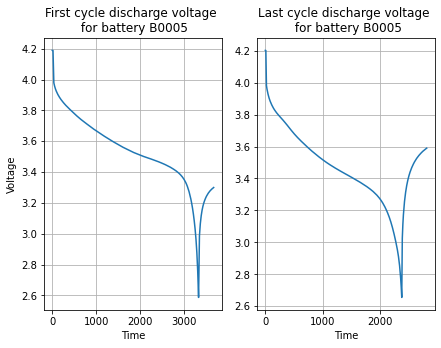

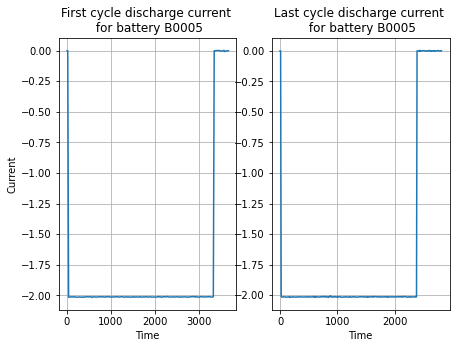

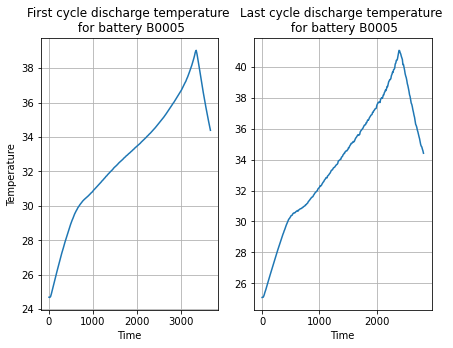

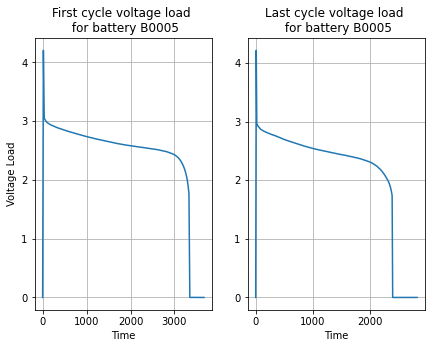

************************************************************************************************************************


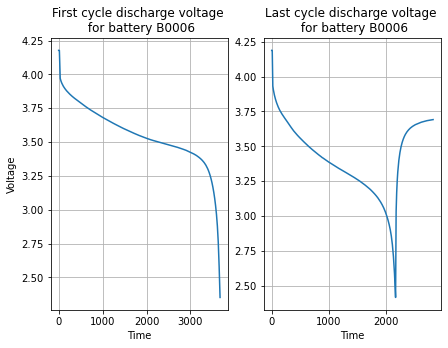

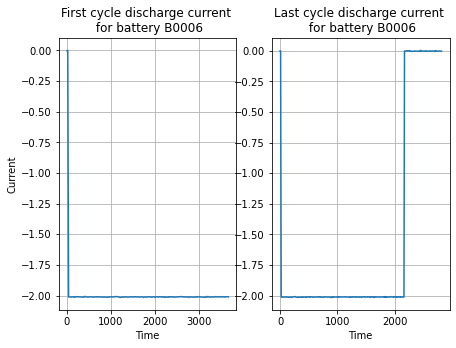

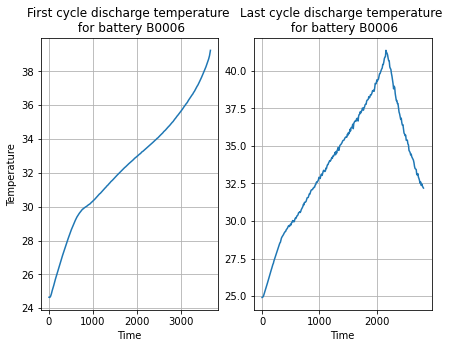

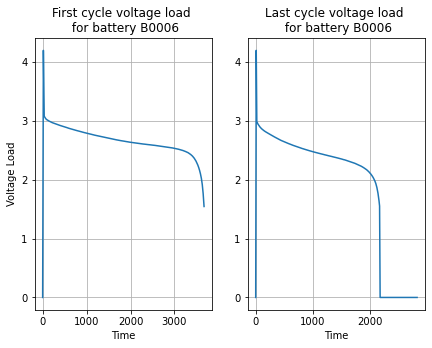

************************************************************************************************************************


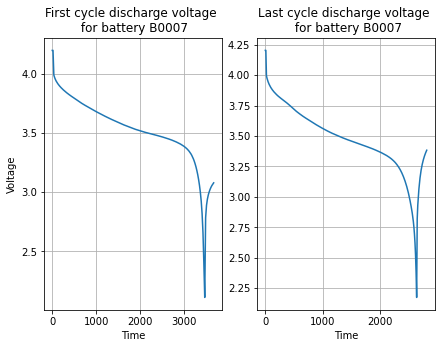

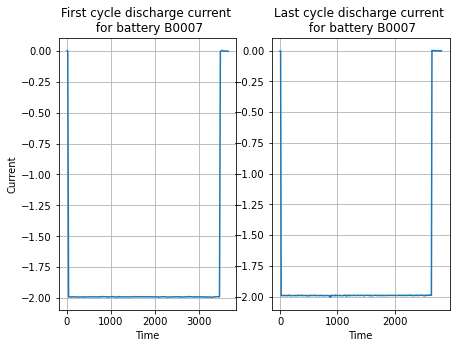

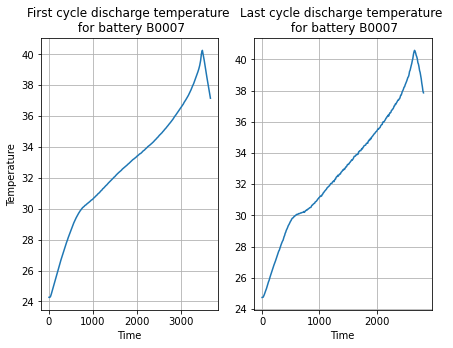

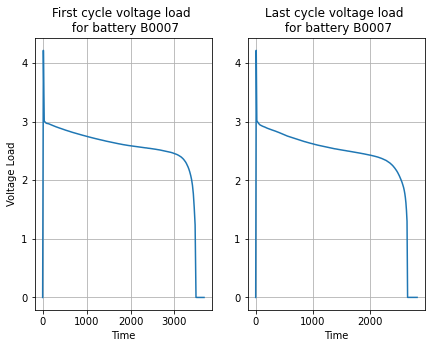

************************************************************************************************************************


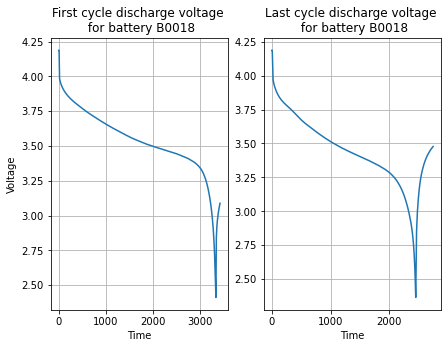

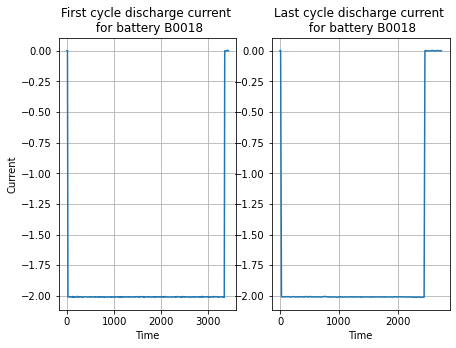

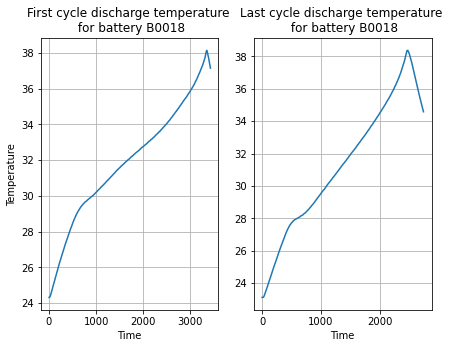

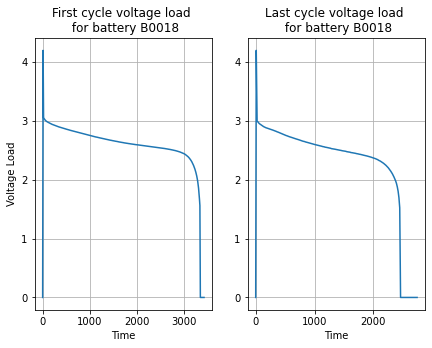

************************************************************************************************************************


In [22]:
#Plotting the first and last charge cycle for voltage, current and temperature

for key,value in data_dict.items():
    #Plotting the Voltage_measured
    #The variables have the same meaning as given earlier
    first = cycle_info_dict[key][0]['discharge'][1]
    last = cycle_info_dict[key][0]['discharge'][-1]
    Voltage_measured_first = value[first]['Voltage_measured']
    time_first = value[first]['Time']
    Voltage_measured_last = value[last]['Voltage_measured']
    time_last = value[last]['Time']

    plt.figure(figsize=(7,5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.title("First cycle discharge voltage \n for battery "+key)
    plt.ylabel("Voltage")
    plt.xlabel("Time")
    plt.plot(time_first,Voltage_measured_first)
    plt.subplot(1, 2, 2)
    plt.plot(time_last,Voltage_measured_last)
    plt.grid()
    plt.title("Last cycle discharge voltage \n for battery "+key)
    plt.xlabel("Time")
    plt.show()



    #Plotting the Current_measured
    Cur_measured_first = value[first]['Current_measured']
    time_first = value[first]['Time']
    Cur_measured_last = value[last]['Current_measured']
    time_last = value[last]['Time']

    plt.figure(figsize=(7,5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.title("First cycle discharge current \n for battery "+key)
    plt.ylabel("Current")
    plt.xlabel("Time")
    plt.plot(time_first,Cur_measured_first)
    plt.subplot(1, 2, 2)
    plt.plot(time_last,Cur_measured_last)
    plt.grid()
    plt.title("Last cycle discharge current \n for battery "+key)
    plt.xlabel("Time")
    plt.show()



    #Plotting the Temperature_measured
    temp_measured_first =value[first]['Temperature_measured']
    time_first = value[first]['Time']
    temp_measured_last = value[last]['Temperature_measured']
    time_last = value[last]['Time']

    plt.figure(figsize=(7,5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.title("First cycle discharge temperature \n for battery "+key)
    plt.ylabel("Temperature")
    plt.xlabel("Time")
    plt.plot(time_first,temp_measured_first)
    plt.subplot(1, 2, 2)
    plt.plot(time_last,temp_measured_last)
    plt.grid()
    plt.title("Last cycle discharge temperature \n for battery "+key)
    plt.xlabel("Time")
    plt.show()

    

    #Plotting the Voltage_charge
    volt_charge_measured_first = value[first]['Voltage_load']
    time_first = value[first]['Time']
    volt_charge_measured_last = value[last]['Voltage_load']
    time_last = value[last]['Time']

    plt.figure(figsize=(7,5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.title("First cycle voltage load \n for battery "+key)
    plt.ylabel("Voltage Load")
    plt.xlabel("Time")
    plt.plot(time_first,volt_charge_measured_first)
    plt.subplot(1, 2, 2)
    plt.plot(time_last,volt_charge_measured_last)
    plt.grid()
    plt.title("Last cycle voltage load \n for battery "+key)
    plt.xlabel("Time")
    plt.show()
    print("*"*120)

Analysing the Voltage curve during charge cycles we have:
1. The voltage curve monotonically decreases from a maximum value to the minimum value.
2. The rate of decrease changes with each cycle

Analysing the charging Current curve:
1. The current remains constant at 2A during discharge of the battery
2. The duration for which the current remains constant at 2A changes with each cycles

Analysing the Temperature curve during the charge cycles:
1. The time at which the temperature reaches the peak changes with each cycle.

<h3>3.8 Now analysing the charge-discharge-impedance cycle sequence for various batteries</h3>

In [23]:
#data_dict contains all the cycles in a list for all the batteries
for key,value in data_dict.items():
    chg_dischg_seq = [i['type'] for i in value]
    print("Charge discharge sequence for battery",key)
    print("From cycle 50 to 65\n",chg_dischg_seq[50:65])
    print("From cycle 200 to 220\n",chg_dischg_seq[200:220])
    print("*"*127)

Charge discharge sequence for battery B0005
From cycle 50 to 65
 ['impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance']
From cycle 200 to 220
 ['discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance', 'discharge', 'charge', 'discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance']
*******************************************************************************************************************************
Charge discharge sequence for battery B0006
From cycle 50 to 65
 ['impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charge', 'impedance']
From cycle 200 to 220
 ['discharge', 'impedance', 'charge', 'impedance', 'discharge', 'impedance', 'charg

Here we get to see charge, discharge and impedance cycles arranged in sequential order however in all of these sequences 
the following sequences are not usual:
1. charge-impedance-charge
2. discharge-impedance-discharge
3. charge-charge
4. discharge-discharge

During impedance cycle the battery is usually kept in high impedance state and does not discharge so we can ignore it 
in the sequence written however, there cannot be any charge-charge or discharge-discharge sequence consecutively. So in the 
next section we would identify them as outliers and remove them.

<h3>3.8.1 Checking if there is any charge-charge or dischage-discharge sequence excluding impedance. These types of sequences are considered outliers</h3>

In [24]:
#removing the impedance cycles
data_filtered_dict = {}
for key,value in data_dict.items():
    filtered_cycle_lst = []
    for i in value:
        if (i['type'] != 'impedance'):
            filtered_cycle_lst.append(i)
    data_filtered_dict[key] = filtered_cycle_lst
    

#anomaly_dict dictionary will hold the anomolous cycles as {battery : [list of anomolous cycles]}

#Here if we have a charge-charge cycle, then the first charge cycle is considered anomolous as after charging once
#the battery cannot be charge unless it is discharged. So the first charge cycle must be anomolour otherwise it 
#cannot be charged in the next cycle.

#and for discharge-discharge cycle, the second discharge cycle is considere anomolous as the battery cannot 
#be discharged after being discharged once.
anomaly_dict = {}
for key,value in data_dict.items():
    anomaly_lst = []
    for i in range(len(data_filtered_dict[key])-1):
        if data_filtered_dict[key][i]['type'] == 'charge':
            if (data_filtered_dict[key][i+1]['type'] == 'charge'):
                print("Anomaly for battery",key, "at index::",i,'having charge-charge sequence')
                anomaly_lst.append(i)
        
        elif data_filtered_dict[key][i]['type'] == 'discharge':
            if (data_filtered_dict[key][i+1]['type'] == 'discharge'):
                print("Anomaly for battery",key, "at index::",i+1,'having discharge-discharge sequence')
                anomaly_lst.append(i+1)    
    print(anomaly_lst)  
    anomaly_dict[key] = anomaly_lst

Anomaly for battery B0005 at index:: 22 having charge-charge sequence
Anomaly for battery B0005 at index:: 179 having discharge-discharge sequence
[22, 179]
Anomaly for battery B0006 at index:: 22 having charge-charge sequence
Anomaly for battery B0006 at index:: 179 having discharge-discharge sequence
[22, 179]
Anomaly for battery B0007 at index:: 22 having charge-charge sequence
Anomaly for battery B0007 at index:: 179 having discharge-discharge sequence
[22, 179]
Anomaly for battery B0018 at index:: 90 having charge-charge sequence
[90]


<h3>3.8.2 Removing the anomalous cycles</h3>

In [25]:

for key,value in data_filtered_dict.items():
    idx = 0
    for i in anomaly_dict[key]:
        data_filtered_dict[key].pop(i-idx)
        idx += 1

<h3>3.8.3 Cycles cannot start with discharge and end with charge. So removing if there is any discharge cycle at index 0 and charge cycle at index -1 </h3>

In [26]:
for key,value in data_filtered_dict.items():
    if value[0]['type'] == 'discharge':
        print("First cycle is discharge so removing it for battery {}".format(key))
        data_filtered_dict[key].pop(0)
    if value[-1]['type'] == 'charge':
        print("Last cycle is charge so removing it")
        data_filtered_dict[key].pop(-1)

There does not seem to be any such battery whose cycles start with discharge and end with charge

<h3>3.8.4 Calculating the number of charge-discharge cycles </h3>

In [27]:
tot_chg_dis_cycle = 0
for key,value in data_filtered_dict.items():
    count = 0
    for i in range(0,len(value),2):
        if (value[i]['type'] == 'charge') and (value[i+1]['type'] == 'discharge') and i < len(value):
            count += 1
    tot_chg_dis_cycle += count
    print("Number of charge-discharge cycles of battery {} is {}".format(key,count))
print("Total charge-discharge cycles from all the batties::",tot_chg_dis_cycle)

Number of charge-discharge cycles of battery B0005 is 167
Number of charge-discharge cycles of battery B0006 is 167
Number of charge-discharge cycles of battery B0007 is 167
Number of charge-discharge cycles of battery B0018 is 132
Total charge-discharge cycles from all the batties:: 633


<h3>3.9 Plotting the capacity curve for the various batteries </h3>

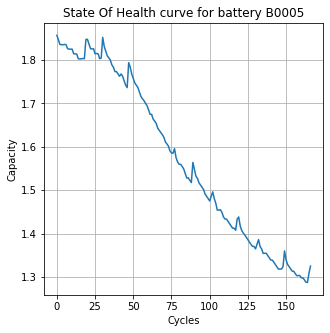

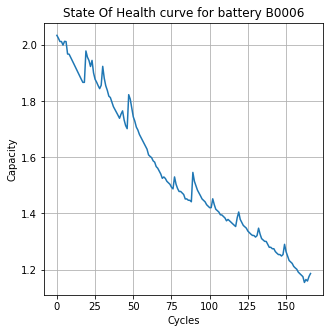

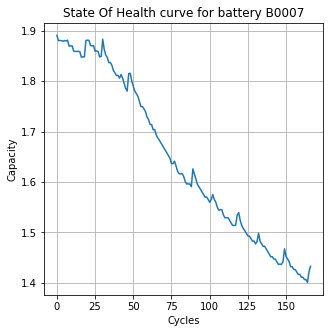

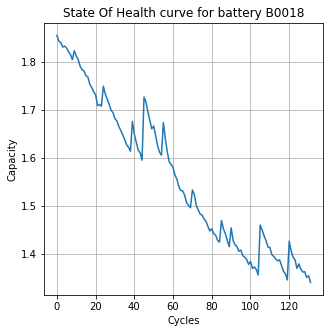

In [28]:
#This dictionary holds the capacity values at the end of each discharge cycle in a list for all the batteries
#The format is {battery : [List of all the capacity at the end of each discharge cycle for the battery]}
capacity_dict = {}
#Plotting the capacity curve for various batteries
for key,value in data_filtered_dict.items():
    capacity_lst = []
    for i in value:
        if i['type'] == 'discharge':
            capacity_lst.append(i['Capacity'])
    capacity_dict[key] = capacity_lst    
    plt.figure(figsize=(5,5))
    plt.plot(capacity_lst)
    plt.grid()
    plt.xlabel("Cycles")
    plt.ylabel("Capacity")
    plt.title("State Of Health curve for battery "+key)
    plt.show()

Here Capacity is the target variable which we need to predict after the end of each charge-discharge cycle. From the capacity curve of all the batteries, it is observed that the value decreases with 
each passing charge-discharge cycle. Hence while engineering the feature, it is required to check 
if the feature either continuously decreases or increases with each cycle in order to have a better 
correlation with the target variable.

<h2>4 Feature analysis and Feature Engineering</h2>

<h3>4.1. Duration for which current was constant during charging cycles</h3>

In [33]:
#This dictionary will hold the duration of time for which the current was more than 1.45A for each charge cycle for a given battery
#The format is: {battery : [List contaning the constant current duration for each charge cycle]}
cc_dur_dict = {}

#data_filtered_dict contains all the cycles after removing the outlier cycles 
for key,value in data_filtered_dict.items():
    #We are storing the constant current duration in this list
    cc_dur_lst = []
    for i in value:
        if i['type'] == 'charge':
            idx = 0
    
            #While calculating the constant current duration we are leaving the first 10 cycles 
            #from the current curve as the current initally rises to reach the constant value
            for j in i['Current_measured'][10:]:
                if (j < 1.45) and idx > 1:
                    #since we have left the first 10 samples so to catch up with the actual time sample value
                    #we are adding 10 with the index to get the exact time sample value
                    time = i['Time'][idx+10]
                    cc_dur_lst.append(time)
                    break
                idx += 1
    cc_dur_dict[key] = cc_dur_lst

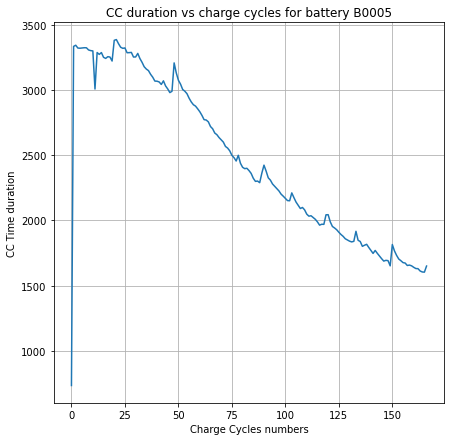

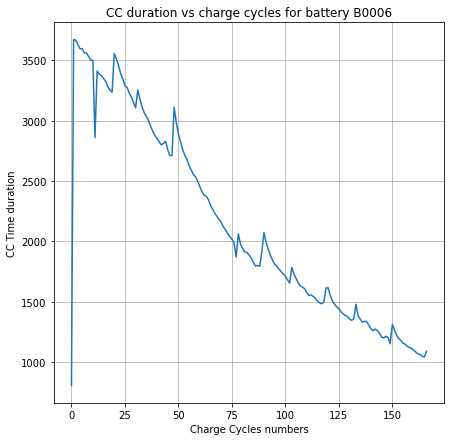

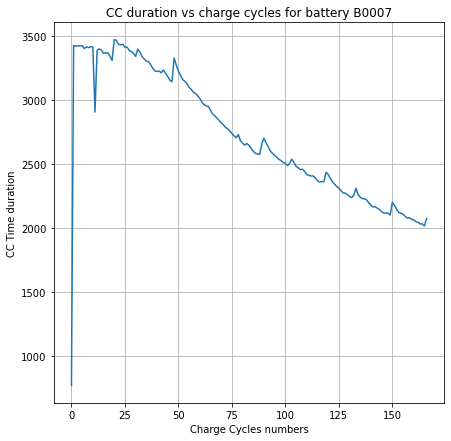

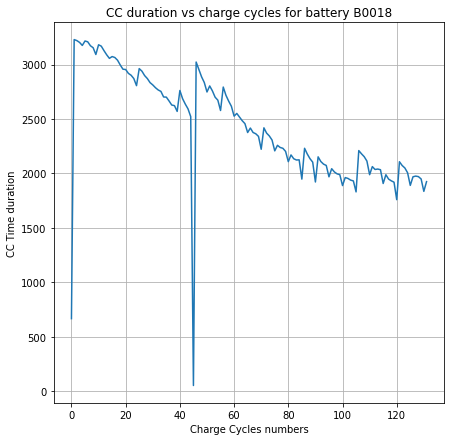

In [34]:
for key,value in cc_dur_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("CC Time duration")
    plt.title("CC duration vs charge cycles for battery "+key)
    plt.show()

The constant current duration decreases continuously for the all the batteries but for the forth battery there is a sharpe decrease between the 40th and 60th cycle. Let us investigate battery B0018 for charging current beyond cycle 40

43 1.522215762681402


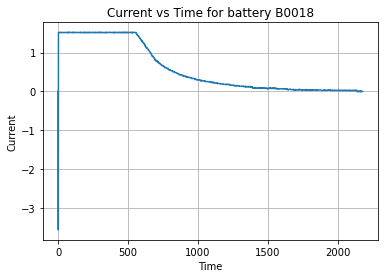

44 1.5211872286178671


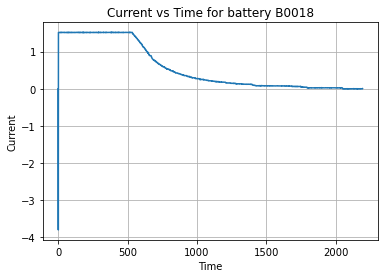

45 1.5175297061795243


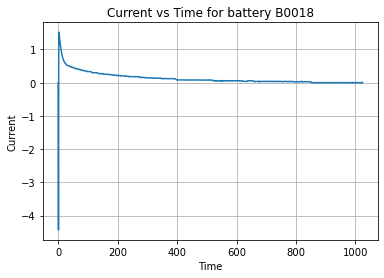

46 1.5213207204756583


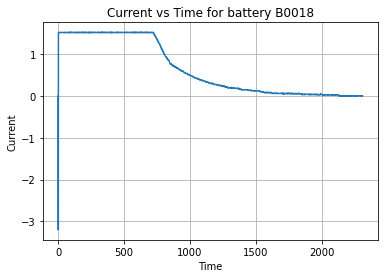

47 1.5227642525989409


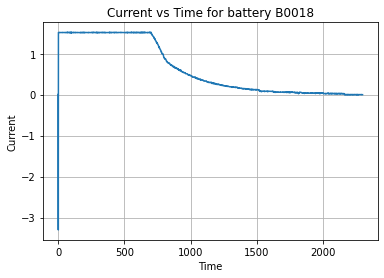

In [35]:
#Plotting the current curve for battery B0018 for charge cycles between 42 to 48
for key,value in data_filtered_dict.items():
    if key == 'B0018':
        idx = 0
        for i in value:
            if i['type'] == 'charge':
                if idx < 48 and idx > 42:
                    print(idx, np.max(i['Current_measured']))
                    plt.plot(i['Current_measured'])
                    plt.grid()
                    plt.xlabel("Time")
                    plt.ylabel("Current")
                    plt.title("Current vs Time for battery "+key)
                    plt.show()
                idx += 1
                

We get to see anomaly during charge cycle number 45 where there is no constant current duration and the same was 
reflected in the Constant current vs Charge cycle plot for battery B0018. We now need to interpolate the value.

In [36]:
for key,value in cc_dur_dict.items():
    if key == 'B0018':
        arr = pd.Series(np.where(cc_dur_dict[key] == np.min(np.array(value)), np.nan, cc_dur_dict[key]))
        cc_dur_dict[key]= arr.interpolate(method='polynomial', order=2).values.tolist()
print(cc_dur_dict['B0018'][45])
        

2770.8430736190166


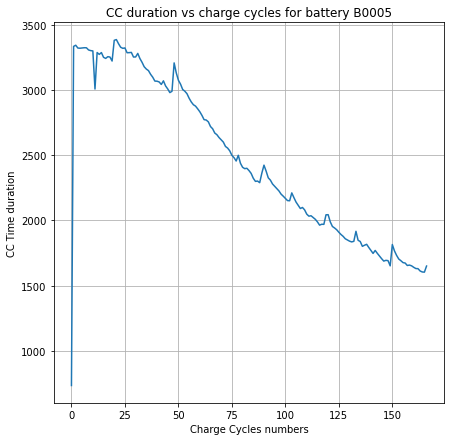

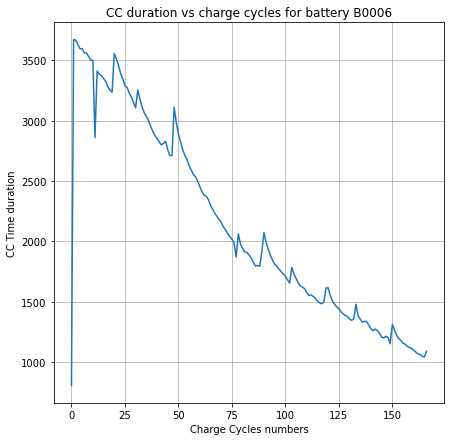

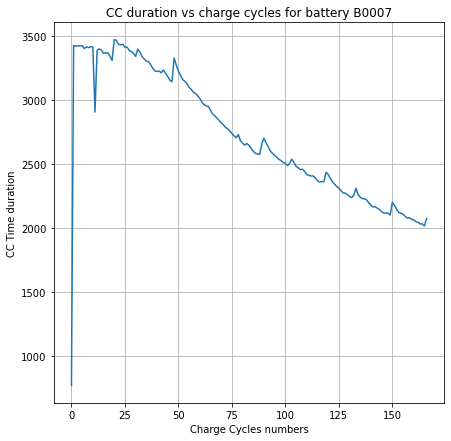

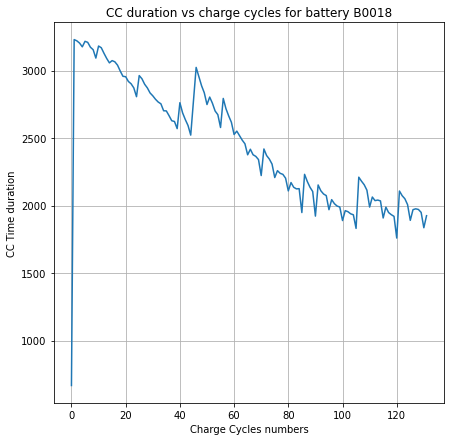

In [37]:
#Plotting the constant current duration vs cycles curves
for key,value in cc_dur_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("CC Time duration")
    plt.title("CC duration vs charge cycles for battery "+key)
    plt.show()

After interpolating the constant current curve, there seems to be a continuous decrease in the value of the constant current 
duration during the charging cycles for all the batteries. Since this feature has positive correlation with the target 
variable so it can be considered as a feature for modelling

<h3>4.2. Duration of constant voltage mode during each charge cycle</h3>

In [38]:
#This dictionary will hold the duration of time for which the voltage was more than or equal to 4.2V 
#for each charge cycle for a given battery
#The format is: {battery : [List contaning the constant voltage duration for each charge cycle]}
cv_dur_dict = {}

for key,value in data_filtered_dict.items():
#This list holds the time duration for which voltage curve was constant at 4.2V
    cv_dur_lst = []
    for i in value:
        if i['type'] == 'charge':
            idx = 0
            for j in i['Voltage_measured']:
                if j >= 4.2:
                    #The voltage curve initially increases from 0 to max value and remains constant at that voltage
                    #here idx is the index at which the voltage has crossed the 4.2 mark.
                    time_thd = i['Time'][idx]
                    time_final = i['Time'][-1]
                    #time-diff is the duration for which the current was more than or equal to 4.2V
                    time_diff = time_final - time_thd
                    cv_dur_lst.append(time_diff)
                    break
                idx += 1
    cv_dur_dict[key] = cv_dur_lst


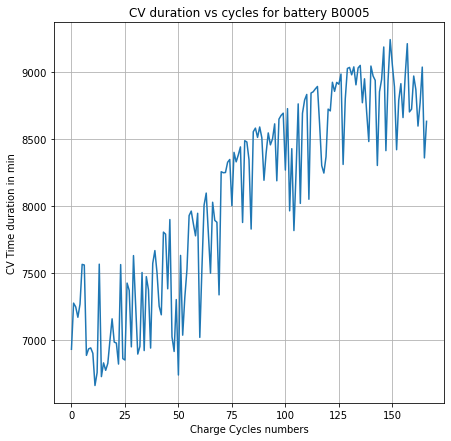

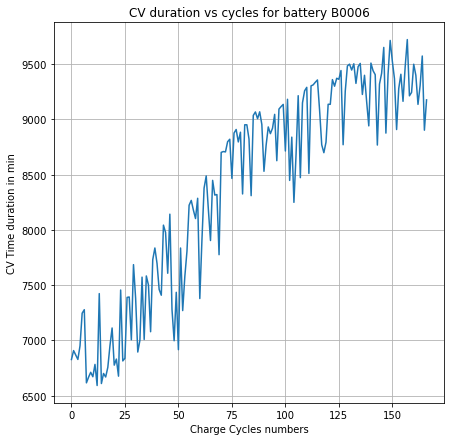

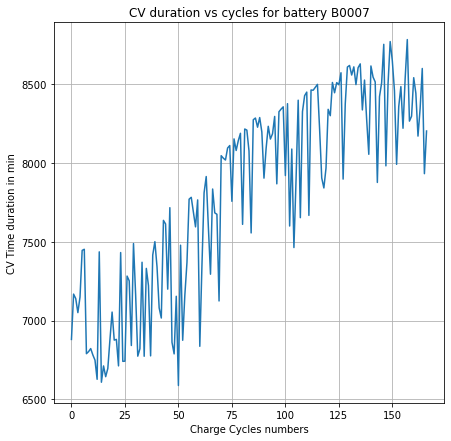

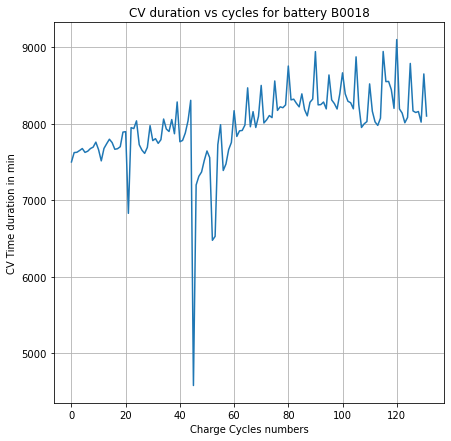

In [39]:
#Plotting the constant voltage curve for the various batteries
for key,value in cv_dur_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("CV Time duration in min")
    plt.title("CV duration vs cycles for battery "+key)
    plt.show()

This feature is very noisy and also non-monotonic at most of the instants. As it doesn't seem to have good correlation with the target variableit won't be good to include it as a feature. So we are not including the Constant Voltage duration as a 
feature for modelling.

<h3>4.3. We will check how much time is required to decrease the temperature from max by 2 degrees during charging cycles</h3>

In [40]:
#This dictionary holds the value of the duration in the temperature curve to decrease by 2 deg from
#the local maxima during charging for all battery
#time_diff_temp_dict has the format: {battery : [List of all the duration ]}
time_diff_temp_dict = {}

for key,value in data_filtered_dict.items():
    #This list holds the duration of time for the temperature to decrease by 2 deg from max value during charging
    time_diff_temp = []
    for i in value:
        if i['type'] == 'charge':
            
            #Getting the index when the time is more than 2000
            idx = 0 
            for time in i['Time']:
                if time > 2000:
                    break
                idx += 1
            
            temp_lst = i['Temperature_measured'][idx:]
            time_lst = i['Time'][idx:]
            t_max = np.max(temp_lst)
            idx_t_max = np.where(temp_lst == t_max)[0][0]
            time_t_max = time_lst[idx_t_max]
            idx = 0
            for j in temp_lst[idx_t_max:]:
                if (j < (t_max -2)):
                    time_t_min = time_lst[idx_t_max+idx]
                    break
                idx += 1
            
            time_diff = time_t_min - time_t_max
            time_diff_temp.append(time_diff)
    time_diff_temp_dict[key] = time_diff_temp

NameError: name 'time_t_min' is not defined

In [41]:
for key,value in time_diff_temp_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("Temp diff by 2")
    plt.title("Temp diff vs cycles for battery "+key)
    plt.show()

This feature seems to have lot of noise and hence not being included as a feature for modelling

<h3>4.4. checking the time diff between max and min temperature during charging cycles</h3>

In [42]:
#this dictionary holds the time difference between the local maxima and minimum value of temperature for all the batteries
time_diff_temp_min_max_dict = {}

for key,value in data_filtered_dict.items():
    #This list holds the duration between the time at which temperature is maximum and minimum during charging cycles
    time_diff_temp_min_max = []
    k=0
    for i in value:
        if i['type'] == 'charge':
            
            #Getting the index when the time is more than 2000
            idx = 0 
            for time in i['Time']:
                if time > 2000:
                    break
                idx += 1
            
            temp_lst = i['Temperature_measured'][idx:]
            t_max = np.max(temp_lst)
            idx_t_max = np.where(temp_lst == t_max)[0][0]
            #Adding idx to compensate for the idx value that were not considered in the temperature list
            time_t_max = i['Time'][idx_t_max+idx]
        
            t_min = np.min(temp_lst)
            idx_t_min = np.where(temp_lst == t_min)[0][0]
            time_t_min = i['Time'][idx_t_min+idx]
        
            time_diff = time_t_min - time_t_max
            time_diff_temp_min_max.append(time_diff)
    time_diff_temp_min_max_dict[key] = time_diff_temp_min_max

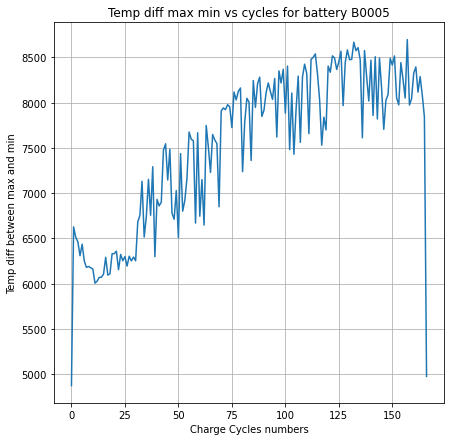

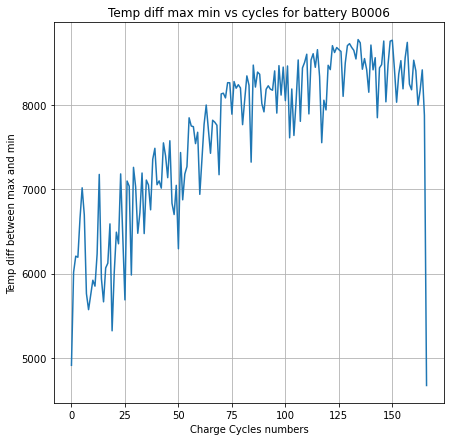

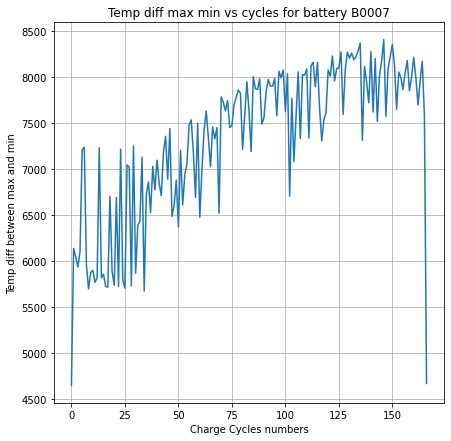

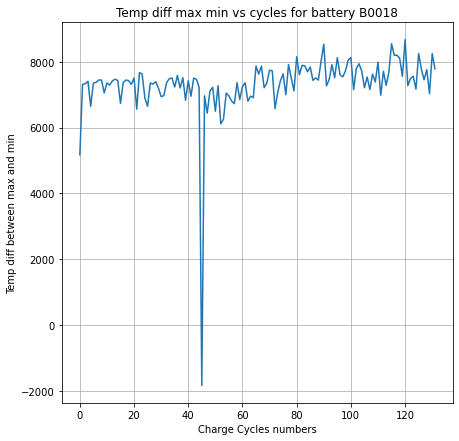

In [43]:
for key,value in time_diff_temp_min_max_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("Temp diff between max and min")
    plt.title("Temp diff max min vs cycles for battery "+key)
    plt.show()

This feature is very noisy and hence not including it as a feature for modelling 

<h3>4.5 Time at which temperature has reached it's maximum value</h3>

In [44]:
#This dictionary holds the time at which the temperature has reached the local maximum value
max_temp_time_dict = {}

for key,value in data_filtered_dict.items():
    #This list holds the time at which temperature reached it highest value
    max_temp_time = []
    for i in value:
        if i['type'] == 'charge':
            #Getting the index when the time is more than 2000
            idx = 0 
            for time in i['Time']:
                if time > 2000:
                    break
                idx += 1
            temp_lst = i['Temperature_measured'][idx:]

            t_max = np.max(temp_lst)
            idx_t_max = np.where(temp_lst == t_max)[0][0]
            time_t_max = i['Time'][idx_t_max+idx]
            max_temp_time.append(time_t_max)
    max_temp_time_dict[key] = max_temp_time

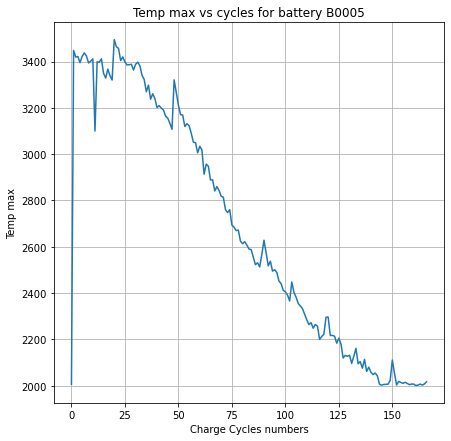

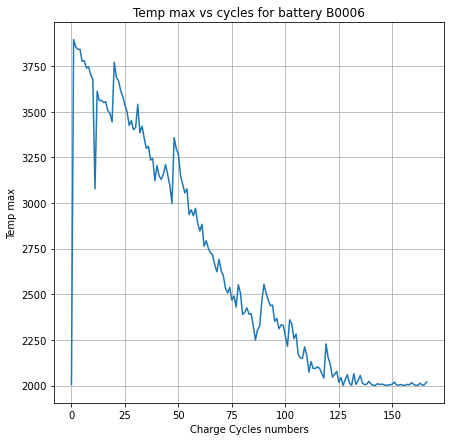

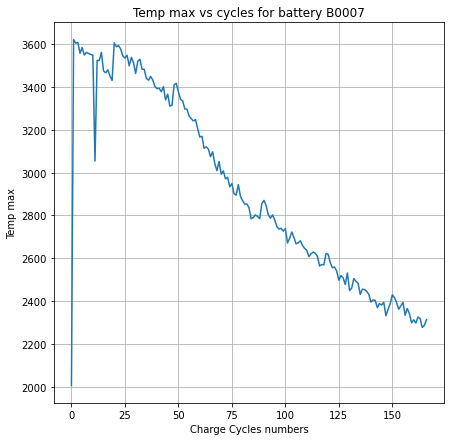

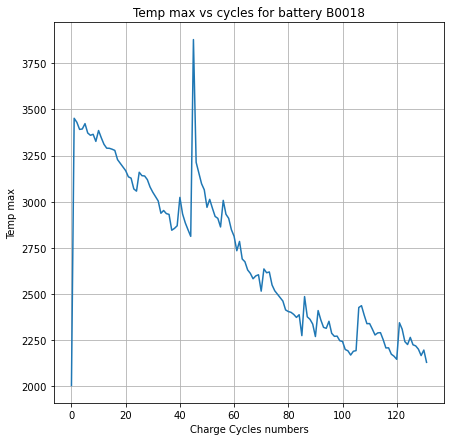

In [45]:
for key,value in max_temp_time_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("Temp max")
    plt.title("Temp max vs cycles for battery "+key)
plt.show()

There is a nice correlation with the capacity of the battery so it can be included as a feature 

<h3>4.6 Time at which temperature has reached it's maximum value during discharge</h3>

In [46]:
#This dictionary holds the time at which the temperature has reached the local maximum value
max_temp_time_dis_dict = {}

for key,value in data_filtered_dict.items():
    #This list holds the time at which temperature reached it highest value
    max_temp_time = []
    for i in value:
        if i['type'] == 'discharge':
            temp_lst = i['Temperature_measured']
            t_max = np.max(temp_lst)
            idx_t_max = np.where(temp_lst == t_max)[0][0]
            time_t_max = i['Time'][idx_t_max]
            max_temp_time.append(time_t_max)
        
    max_temp_time_dis_dict[key] = max_temp_time

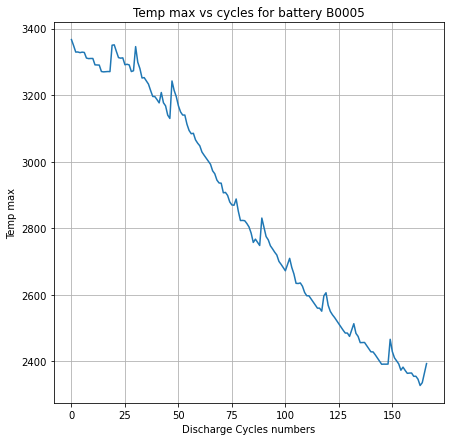

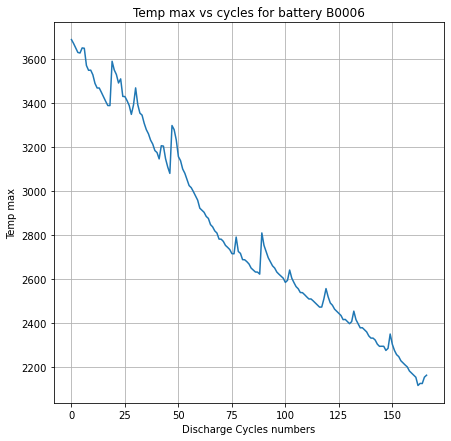

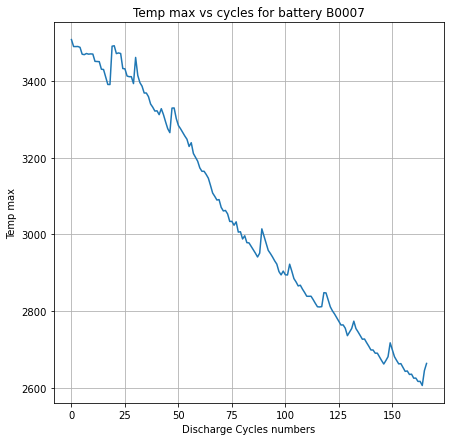

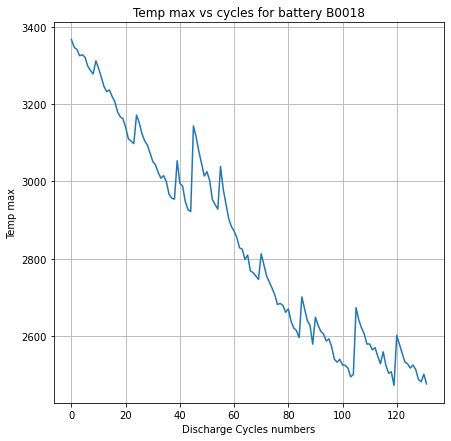

In [47]:
for key,value in max_temp_time_dis_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Discharge Cycles numbers")
    plt.ylabel("Temp max")
    plt.title("Temp max vs cycles for battery "+key)
plt.show()

There is a nice correlation with the capacity of the battery so it can be included as a feature 

<h3>4.7. Difference between the max and avg value of temperature during charge cycles</h3>

In [48]:
#This dictionary holds the difference between the max and avg value of 
max_avg_temp_val_dict = {}

for key,value in data_filtered_dict.items():
    max_avg_temp_val = []
    for i in value:
        if i['type'] == 'charge':
            temp_max = np.max(i['Temperature_measured'])
            temp_avg = np.mean(i['Temperature_measured'])
            max_avg_temp_val.append(temp_max-temp_avg)
    max_avg_temp_val_dict[key] = max_avg_temp_val

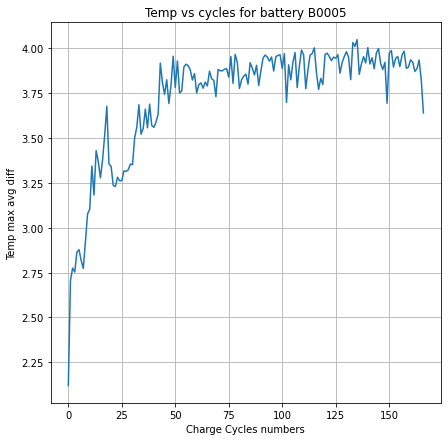

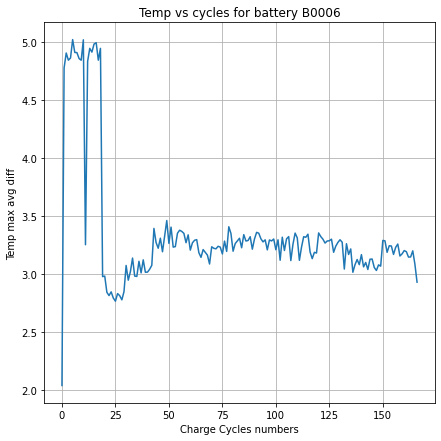

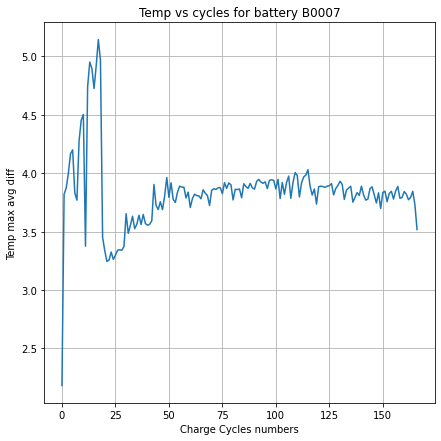

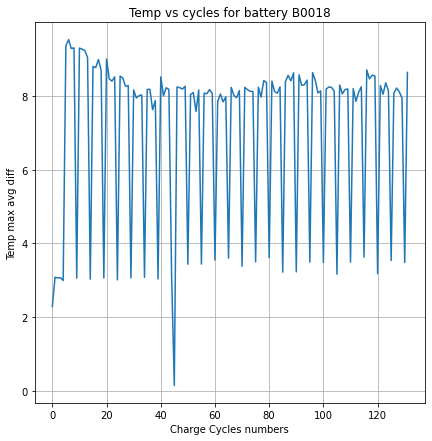

In [49]:
for key,value in max_avg_temp_val_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("Temp max avg diff")
    plt.title("Temp vs cycles for battery "+key)
    plt.show()

This curve is very noisy and not good to take it as a feature for modelling

<h3>4.8. Calculating the min voltage time during discharge cycles</h3>

In [50]:
####################################
min_vol_dur_dict = {}
overall_grad_dict = {}
for key,value in data_filtered_dict.items():
    min_vol_dur = []
    overall_grad_lst = []
    
    for i in value:
        if i['type'] == 'discharge':
            #min_vol_index = np.where(i['Voltage_measured'] == np.min(i['Voltage_measured']))[0][0]
            #min_vol_dur.append(min_vol_index)
            temp_lst = i['Voltage_measured']
            idx = 0
            for ele in temp_lst:
                if ele < 2.7:
                    break
                idx += 1
            
            v_min = temp_lst[idx]
            #print(key,idx_i,v_min)
            #idx_v_min = np.where(temp_lst == v_min)[0][0]
            time_v_min = i['Time'][idx]
            min_vol_dur.append(time_v_min)
            overall_grad = (4.2-2.7)/time_v_min
            overall_grad_lst.append(overall_grad)
    
    min_vol_dur_dict[key] = min_vol_dur
    overall_grad_dict[key] = overall_grad_lst

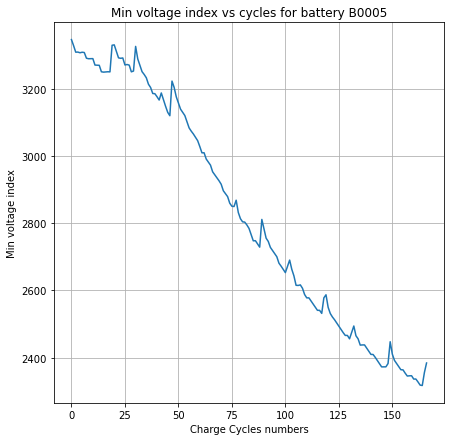

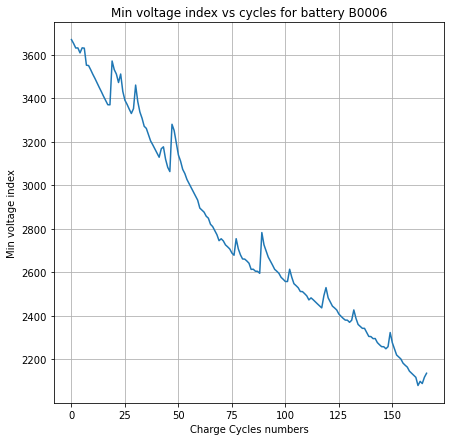

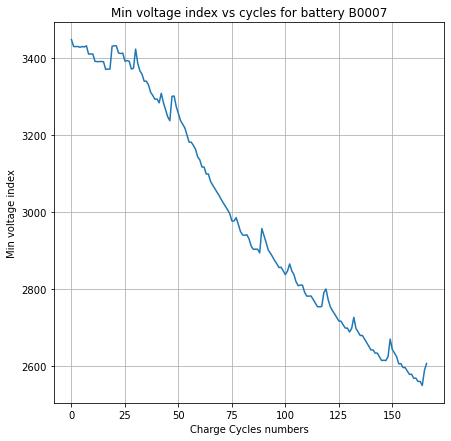

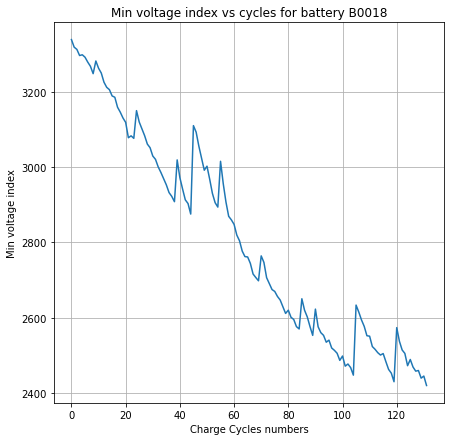

In [51]:
for key,value in min_vol_dur_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("Min voltage index")
    plt.title("Min voltage index vs cycles for battery "+ key)
    plt.show()

This has good correlation with the capacity so it can be used as a feature 

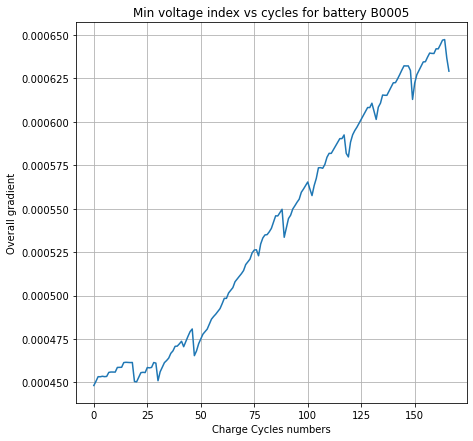

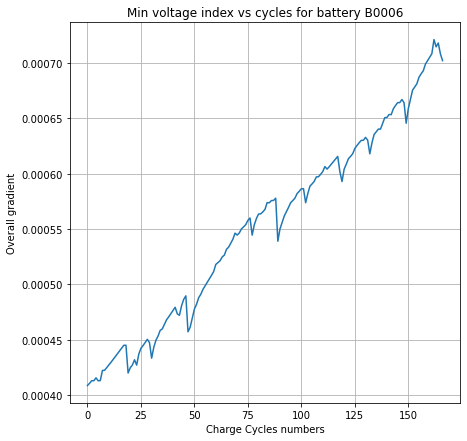

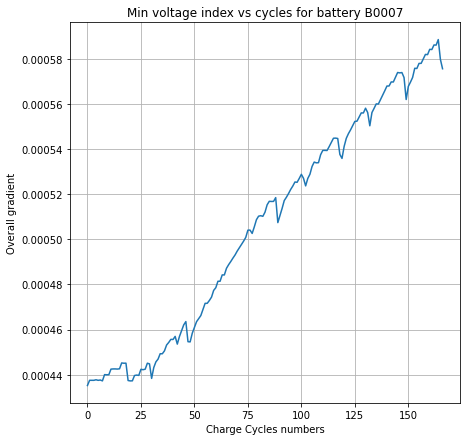

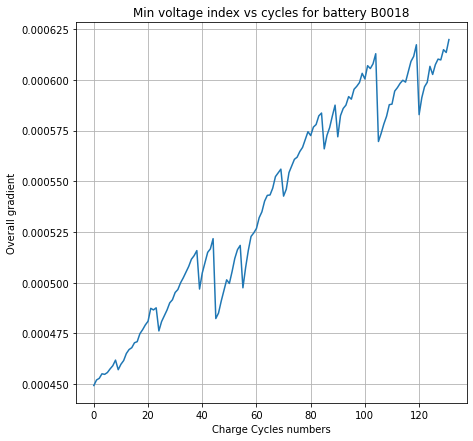

In [52]:
for key,value in overall_grad_dict.items():
    plt.figure(figsize=(7,7))
    plt.plot(value)
    plt.grid()
    plt.xlabel("Charge Cycles numbers")
    plt.ylabel("Overall gradient")
    plt.title("Min voltage index vs cycles for battery "+ key)
    plt.show()

<h3>4.9. Here all the features for the various batteries are put together in a single list</h3>

In [60]:
cc_dur_lst = []
max_temp_time = []
max_temp_time_dis = []
overall_grad_vol = []
min_vol_dur = []
capacity_lst = []

for key,value in data_filtered_dict.items():
    cc_dur_lst += cc_dur_dict[key]
    overall_grad_vol += overall_grad_dict[key]
    max_temp_time += max_temp_time_dict[key]
    max_temp_time_dis += max_temp_time_dis_dict[key]
    min_vol_dur += min_vol_dur_dict[key]
    capacity_lst += capacity_dict[key]
    
print(len(cc_dur_lst),len(max_temp_time),len(max_temp_time_dis),len(min_vol_dur),
      len(capacity_lst),len(overall_grad_vol))


633 633 633 633 633 633


<h3>5. Creating the Dataframe</h3>

In [61]:
df = pd.DataFrame()
df['CC_Duration_Charge'] = cc_dur_lst
df['Overall_Grad_Vol'] = overall_grad_vol
df['Max_Temp_Time_Charge'] = max_temp_time
df['Max_Temp_Time_Discharge'] = max_temp_time_dis
df['Min_Volt_Time_Discharge'] = min_vol_dur
df['Capacity'] = capacity_lst

In [62]:
df.head()

,CC_Duration_Charge,Overall_Grad_Vol,Max_Temp_Time_Charge,Max_Temp_Time_Discharge,Min_Volt_Time_Discharge,Capacity
0,733.297,0.000448,2005.797,3366.781,3346.937,1.856487
1,3336.391,0.000451,3447.609,3348.735,3328.828,1.846327
2,3345.234,0.000453,3419.156,3329.281,3309.422,1.835349
3,3323.656,0.000453,3421.593,3329.500,3309.719,1.835263
4,3322.359,0.000453,3395.125,3327.531,3307.688,1.834646


In [63]:
df.count()

CC_Duration_Charge         633
Overall_Grad_Vol           633
Max_Temp_Time_Charge       633
Max_Temp_Time_Discharge    633
Min_Volt_Time_Discharge    633
Capacity                   633
dtype: int64

In [64]:
df.to_csv("Final Dataset/"+'battery'+".csv")

<h2>6. Correlation Analysis among the features</h2>

Here we are performing both univariate and bivariate analysis. For the univariate analysis we check the correlation between
the target variable and the various features engineered from the charge-discharge curves. And for the bi-variate analysis we 
check the correlation between two features.

In [65]:
#Getting the correlation among the features
df_corr = df.corr(method ='pearson')

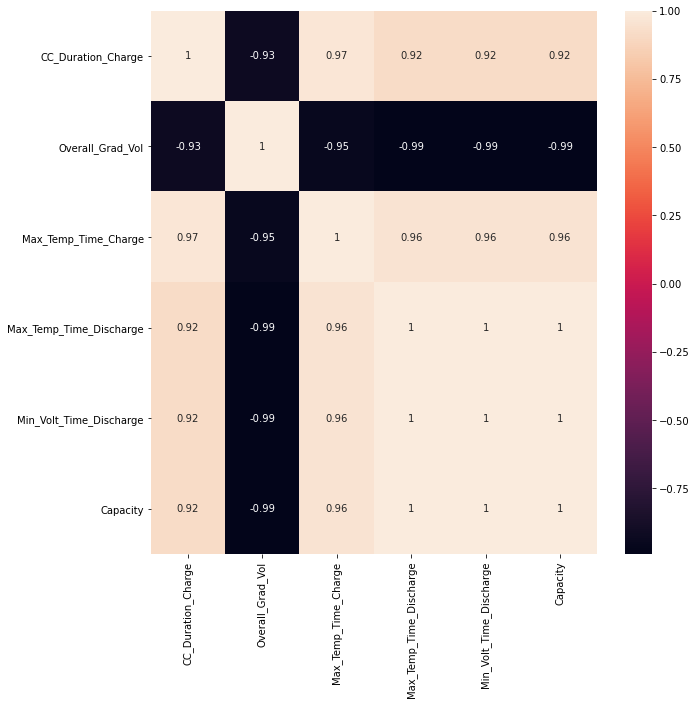

In [66]:
plt.figure(figsize=(10,10))
hm = sn.heatmap(data = df_corr,annot=True)  
plt.show()

<h3>6.2 Plotting the Correlation values as a bar plot</h3>

In [67]:
#The values of the correlation
df_corr.iloc[5,:-1].abs().tolist()

[0.9185878205346502,
 0.9907480081939563,
 0.9561047763680276,
 0.9972701951097374,
 0.999286434862373]

In [57]:
#The names of the columns
df.columns[:-1].tolist()

['CC_Duration_Charge',
 'Overall_Grad_Vol',
 'Max_Temp_Time_Charge',
 'Max_Temp_Time_Discharge',
 'Min_Volt_Time_Discharge']

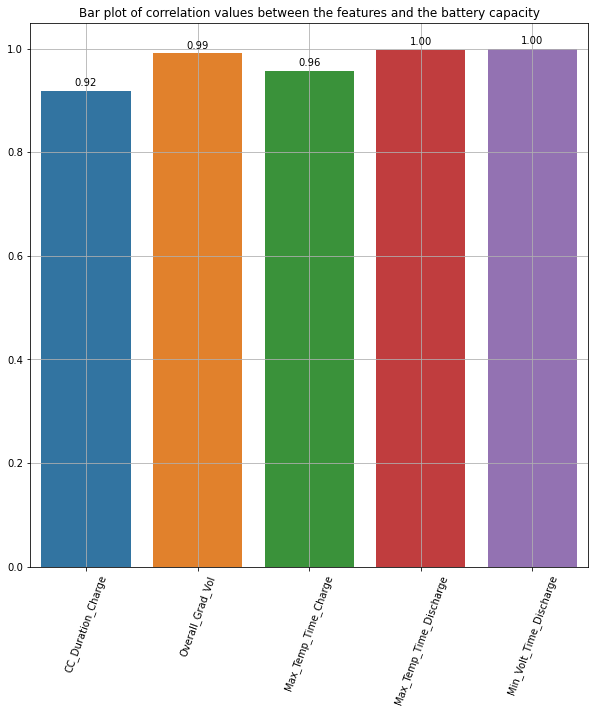

In [58]:
    plt.figure(figsize=(10,10))
    plt.title('Bar plot of correlation values between the features and the battery capacity')
    ax = sns.barplot(x=list(df.columns[:-1].tolist()), 
            y=df_corr.iloc[5,:-1].abs().tolist())
    plt.xticks(rotation=70)

    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

    plt.grid()
    plt.show()

In the correlation plot and the bar plot we get to see that the features which are having high correlation with the target variable 'Capacity'
are:

1. CC_Duration_Charge
2. Overall_Grad_Voll
3. Max_Temp_Time_Charge
4. Max_Temp_Time_Discharge
5. Min_Volt_Time_Discharge      

Out of all these features we would be taking the following feature considering both the correlation with the target 
variable and the ease of data input by a user 


1. CC_Duration_Charge                                                 
2. Max_Temp_Time_Charge
3. Max_Temp_Time_Discharge
4. Min_Volt_Time_Discharge 


Hence for modelling we would be taking these four features and campare the performace of difference 
Machine Learning models

In [120]:
df_total.to_csv("query.csv")